In [35]:
import numpy as np
import lightgbm as lgb
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error 
from sklearn.model_selection import KFold,StratifiedKFold


In [2]:
# train = pd.read_pickle('df_train.pickle')
# test = pd.read_pickle('df_test.pickle')

train = pd.read_csv('df_train_2_extra.csv')
test = pd.read_csv('df_test_2_extra.csv')
#target = np.loadtxt('wang.target.txt')
target=train['target']
outlier=train['outliers']
#outlier = np.zeros(len(target), dtype=np.int)
#outlier[target < -33] = 1

In [3]:
test.shape

(123623, 255)

#### outlier ratio

In [4]:
outlier.sum() / len(outlier)

0.010930233709890698

In [5]:
feats = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]

In [6]:
target_with_outlier = pd.DataFrame({
    'target': target,
    'outlier': outlier
})

In [7]:
test.shape[0]/(train.shape[0]+test.shape[0])

0.379747496467408

## I am going to use 20% and 10% of data as test set. Let's start with 20%

In [65]:
df_train, df_test, y_train, y_test = train_test_split(train, target_with_outlier, test_size=0.20, random_state=12)

In [66]:
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((161533, 257), (40384, 257), (161533, 2), (40384, 2))

In [67]:
y_train.outlier.mean(),y_test.outlier.mean()

(0.010932750583472107, 0.010920166402535658)

In [15]:
def get_lb(pred_target):
    return mean_squared_error(y_test.target, pred_target) ** 0.5

In [34]:
### I will use different number of features as train set
feats1=pd.read_csv('threshold_feature_elimination10_2extra_test10.csv', squeeze=True).tolist()
feats2=pd.read_csv('threshold_feature_elimination50_2extra_test10.csv', squeeze=True).tolist()
feats3=pd.read_csv('threshold_feature_elimination70_2extra_test10.csv', squeeze=True).tolist()


In [33]:
len(feats),len(feats1),len(feats2),len(feats3)

(253, 150, 91, 72)

In [37]:
# Fixed parameters for all training
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 6,
         "random_state": 4950}

In [41]:
def regression(df_train,df_test,fold,feature):
    results=pd.DataFrame()
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=4950)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    val_error=[]
    test_error=[]
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):

        # cal the outlier ratio for each fold
        cur_fold= df_train.iloc[trn_idx]
        number_outliers = len(cur_fold[cur_fold['outliers'] == 1])
        total = len(cur_fold)
        print("fold %s %s %s" % (fold_,number_outliers, number_outliers / total))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][feature], label=y_train.target.iloc[trn_idx])
        val_data = lgb.Dataset(df_train.iloc[val_idx][feature], label=y_train.target.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 600)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][feature], num_iteration=clf.best_iteration)
        oof_test=clf.predict(df_test[feature], num_iteration=clf.best_iteration)
        
        val_error.append(np.sqrt(mean_squared_error(oof[val_idx], y_train.target.iloc[val_idx])))
        test_error.append(np.sqrt(mean_squared_error(oof_test, y_test.target)))
        
        predictions += clf.predict(df_test[feature], num_iteration=clf.best_iteration) / folds.n_splits
    results['cv_error']=val_error
    results['test_error']=test_error
    results['fold']=[i for i in range(1,fold+1,1)]
    results['ave_cv_error']=np.sqrt(mean_squared_error(oof,  y_train.target))
    results['ave_test_error']=np.sqrt(mean_squared_error(predictions, y_test.target))

    return results

In [90]:
feat_names=['feats','feats1','feats2','feats3']
df_all=pd.DataFrame()
for fold in [5,6,7,8,9,10]:
    df_total=pd.DataFrame()
    for feat in [feats,feats1,feats2,feats3]:
        df=regression(df_train,df_test,fold,feat)
        df['feats']=feat_names[[feats,feats1,feats2,feats3].index(feat)] # indicate feat
        df_total=pd.concat([df_total,df],axis=0) # data frame for each feat
    df_total['num_folds']=fold # indicate fold number
    df_all=pd.concat([df_all,df_total],axis=0) # data frame for each fold
    

fold 0 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.62935	valid_1's rmse: 3.71384
[200]	training's rmse: 3.52828	valid_1's rmse: 3.68523
[300]	training's rmse: 3.46763	valid_1's rmse: 3.67322
[400]	training's rmse: 3.42191	valid_1's rmse: 3.66686
[500]	training's rmse: 3.38514	valid_1's rmse: 3.6633
[600]	training's rmse: 3.35347	valid_1's rmse: 3.66153
[700]	training's rmse: 3.3255	valid_1's rmse: 3.66107
[800]	training's rmse: 3.29924	valid_1's rmse: 3.65998
[900]	training's rmse: 3.27402	valid_1's rmse: 3.66058
[1000]	training's rmse: 3.25103	valid_1's rmse: 3.66049
[1100]	training's rmse: 3.22944	valid_1's rmse: 3.66004
[1200]	training's rmse: 3.20855	valid_1's rmse: 3.66024
[1300]	training's rmse: 3.18737	valid_1's rmse: 3.66043
[1400]	training's rmse: 3.1652	valid_1's rmse: 3.66044
[1500]	training's rmse: 3.14578	valid_1's rmse: 3.66084
[1600]	training's rmse: 3.12707	valid_1's rmse: 3.66112
[1700]	training's rm

[700]	training's rmse: 3.33801	valid_1's rmse: 3.66641
[800]	training's rmse: 3.31369	valid_1's rmse: 3.66543
[900]	training's rmse: 3.29032	valid_1's rmse: 3.66477
[1000]	training's rmse: 3.26807	valid_1's rmse: 3.66506
[1100]	training's rmse: 3.24712	valid_1's rmse: 3.6651
[1200]	training's rmse: 3.22671	valid_1's rmse: 3.66515
[1300]	training's rmse: 3.20642	valid_1's rmse: 3.66575
[1400]	training's rmse: 3.18707	valid_1's rmse: 3.66597
[1500]	training's rmse: 3.16854	valid_1's rmse: 3.66682
Early stopping, best iteration is:
[903]	training's rmse: 3.28971	valid_1's rmse: 3.66471
fold 3 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64044	valid_1's rmse: 3.7063
[200]	training's rmse: 3.54512	valid_1's rmse: 3.6649
[300]	training's rmse: 3.48746	valid_1's rmse: 3.64915
[400]	training's rmse: 3.44415	valid_1's rmse: 3.64022
[500]	training's rmse: 3.40759	valid_1's rmse: 3.63527
[600]	training's rmse: 3.37668	valid_1's 

[1000]	training's rmse: 3.29094	valid_1's rmse: 3.68246
[1100]	training's rmse: 3.27143	valid_1's rmse: 3.68264
[1200]	training's rmse: 3.25285	valid_1's rmse: 3.68262
[1300]	training's rmse: 3.23409	valid_1's rmse: 3.68277
[1400]	training's rmse: 3.21702	valid_1's rmse: 3.6831
[1500]	training's rmse: 3.20026	valid_1's rmse: 3.68287
[1600]	training's rmse: 3.18478	valid_1's rmse: 3.68334
Early stopping, best iteration is:
[1009]	training's rmse: 3.28909	valid_1's rmse: 3.68238
fold 0 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64517	valid_1's rmse: 3.70989
[200]	training's rmse: 3.55521	valid_1's rmse: 3.67776
[300]	training's rmse: 3.50313	valid_1's rmse: 3.66758
[400]	training's rmse: 3.46281	valid_1's rmse: 3.66244
[500]	training's rmse: 3.4319	valid_1's rmse: 3.65951
[600]	training's rmse: 3.40508	valid_1's rmse: 3.6577
[700]	training's rmse: 3.38121	valid_1's rmse: 3.65648
[800]	training's rmse: 3.35916	valid_1'

Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.63853	valid_1's rmse: 3.69663
[200]	training's rmse: 3.54206	valid_1's rmse: 3.65832
[300]	training's rmse: 3.48262	valid_1's rmse: 3.64366
[400]	training's rmse: 3.43872	valid_1's rmse: 3.63589
[500]	training's rmse: 3.40254	valid_1's rmse: 3.63125
[600]	training's rmse: 3.37107	valid_1's rmse: 3.62724
[700]	training's rmse: 3.34405	valid_1's rmse: 3.62576
[800]	training's rmse: 3.31848	valid_1's rmse: 3.6246
[900]	training's rmse: 3.29314	valid_1's rmse: 3.62408
[1000]	training's rmse: 3.2696	valid_1's rmse: 3.62324
[1100]	training's rmse: 3.2463	valid_1's rmse: 3.62327
[1200]	training's rmse: 3.22554	valid_1's rmse: 3.62373
[1300]	training's rmse: 3.20503	valid_1's rmse: 3.62379
[1400]	training's rmse: 3.18477	valid_1's rmse: 3.62392
[1500]	training's rmse: 3.16562	valid_1's rmse: 3.6248
[1600]	training's rmse: 3.14774	valid_1's rmse: 3.62523
Early stopping, best iteration is:
[1072]	training's r

[900]	training's rmse: 3.31383	valid_1's rmse: 3.62243
[1000]	training's rmse: 3.29229	valid_1's rmse: 3.62227
[1100]	training's rmse: 3.27173	valid_1's rmse: 3.62308
[1200]	training's rmse: 3.2517	valid_1's rmse: 3.62408
[1300]	training's rmse: 3.23194	valid_1's rmse: 3.62451
[1400]	training's rmse: 3.21354	valid_1's rmse: 3.62482
[1500]	training's rmse: 3.1955	valid_1's rmse: 3.625
Early stopping, best iteration is:
[989]	training's rmse: 3.29457	valid_1's rmse: 3.6221
fold 3 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.63817	valid_1's rmse: 3.70639
[200]	training's rmse: 3.54062	valid_1's rmse: 3.67531
[300]	training's rmse: 3.48234	valid_1's rmse: 3.66304
[400]	training's rmse: 3.4393	valid_1's rmse: 3.65665
[500]	training's rmse: 3.40393	valid_1's rmse: 3.65386
[600]	training's rmse: 3.37336	valid_1's rmse: 3.65222
[700]	training's rmse: 3.34581	valid_1's rmse: 3.65121
[800]	training's rmse: 3.32075	valid_1's rms

[100]	training's rmse: 3.64405	valid_1's rmse: 3.70908
[200]	training's rmse: 3.55529	valid_1's rmse: 3.6692
[300]	training's rmse: 3.50213	valid_1's rmse: 3.65481
[400]	training's rmse: 3.46271	valid_1's rmse: 3.64535
[500]	training's rmse: 3.42981	valid_1's rmse: 3.64013
[600]	training's rmse: 3.40061	valid_1's rmse: 3.63589
[700]	training's rmse: 3.37715	valid_1's rmse: 3.63324
[800]	training's rmse: 3.35485	valid_1's rmse: 3.6315
[900]	training's rmse: 3.33375	valid_1's rmse: 3.63012
[1000]	training's rmse: 3.31507	valid_1's rmse: 3.62973
[1100]	training's rmse: 3.2961	valid_1's rmse: 3.62901
[1200]	training's rmse: 3.27898	valid_1's rmse: 3.62841
[1300]	training's rmse: 3.26147	valid_1's rmse: 3.62857
[1400]	training's rmse: 3.24401	valid_1's rmse: 3.62845
[1500]	training's rmse: 3.22668	valid_1's rmse: 3.62802
[1600]	training's rmse: 3.21036	valid_1's rmse: 3.62857
[1700]	training's rmse: 3.19426	valid_1's rmse: 3.62869
[1800]	training's rmse: 3.17813	valid_1's rmse: 3.62922
[190

[1500]	training's rmse: 3.22434	valid_1's rmse: 3.68232
[1600]	training's rmse: 3.20845	valid_1's rmse: 3.68234
Early stopping, best iteration is:
[1039]	training's rmse: 3.30286	valid_1's rmse: 3.68079
fold 0 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.6347	valid_1's rmse: 3.71231
[200]	training's rmse: 3.5372	valid_1's rmse: 3.68356
[300]	training's rmse: 3.47884	valid_1's rmse: 3.67303
[400]	training's rmse: 3.4342	valid_1's rmse: 3.6661
[500]	training's rmse: 3.3993	valid_1's rmse: 3.66289
[600]	training's rmse: 3.36883	valid_1's rmse: 3.66016
[700]	training's rmse: 3.33989	valid_1's rmse: 3.65926
[800]	training's rmse: 3.31465	valid_1's rmse: 3.65809
[900]	training's rmse: 3.28981	valid_1's rmse: 3.65777
[1000]	training's rmse: 3.2678	valid_1's rmse: 3.6577
[1100]	training's rmse: 3.24629	valid_1's rmse: 3.65799
[1200]	training's rmse: 3.22542	valid_1's rmse: 3.65784
[1300]	training's rmse: 3.20597	valid_1's rms

[100]	training's rmse: 3.64008	valid_1's rmse: 3.71199
[200]	training's rmse: 3.54642	valid_1's rmse: 3.68292
[300]	training's rmse: 3.49123	valid_1's rmse: 3.67083
[400]	training's rmse: 3.44858	valid_1's rmse: 3.66505
[500]	training's rmse: 3.41406	valid_1's rmse: 3.66068
[600]	training's rmse: 3.38388	valid_1's rmse: 3.65818
[700]	training's rmse: 3.35781	valid_1's rmse: 3.65648
[800]	training's rmse: 3.33348	valid_1's rmse: 3.6551
[900]	training's rmse: 3.31077	valid_1's rmse: 3.65472
[1000]	training's rmse: 3.29045	valid_1's rmse: 3.65466
[1100]	training's rmse: 3.27	valid_1's rmse: 3.65457
[1200]	training's rmse: 3.25136	valid_1's rmse: 3.65375
[1300]	training's rmse: 3.2331	valid_1's rmse: 3.65362
[1400]	training's rmse: 3.2158	valid_1's rmse: 3.65354
[1500]	training's rmse: 3.19989	valid_1's rmse: 3.65334
[1600]	training's rmse: 3.18207	valid_1's rmse: 3.65384
[1700]	training's rmse: 3.16541	valid_1's rmse: 3.65391
[1800]	training's rmse: 3.14984	valid_1's rmse: 3.6542
[1900]	t

[600]	training's rmse: 3.40475	valid_1's rmse: 3.65097
[700]	training's rmse: 3.38008	valid_1's rmse: 3.65004
[800]	training's rmse: 3.35846	valid_1's rmse: 3.64903
[900]	training's rmse: 3.3364	valid_1's rmse: 3.64882
[1000]	training's rmse: 3.31667	valid_1's rmse: 3.64864
[1100]	training's rmse: 3.29717	valid_1's rmse: 3.64816
[1200]	training's rmse: 3.27966	valid_1's rmse: 3.64769
[1300]	training's rmse: 3.26237	valid_1's rmse: 3.64818
[1400]	training's rmse: 3.24599	valid_1's rmse: 3.64804
[1500]	training's rmse: 3.22933	valid_1's rmse: 3.6477
[1600]	training's rmse: 3.21333	valid_1's rmse: 3.6485
[1700]	training's rmse: 3.19784	valid_1's rmse: 3.64906
Early stopping, best iteration is:
[1163]	training's rmse: 3.28676	valid_1's rmse: 3.64756
fold 1 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64507	valid_1's rmse: 3.71668
[200]	training's rmse: 3.55582	valid_1's rmse: 3.68159
[300]	training's rmse: 3.50162	valid_1

[1200]	training's rmse: 3.29146	valid_1's rmse: 3.65091
[1300]	training's rmse: 3.27507	valid_1's rmse: 3.65097
[1400]	training's rmse: 3.25808	valid_1's rmse: 3.65079
[1500]	training's rmse: 3.24129	valid_1's rmse: 3.65032
[1600]	training's rmse: 3.22507	valid_1's rmse: 3.65134
[1700]	training's rmse: 3.20936	valid_1's rmse: 3.65162
[1800]	training's rmse: 3.19429	valid_1's rmse: 3.65176
[1900]	training's rmse: 3.17956	valid_1's rmse: 3.65242
[2000]	training's rmse: 3.1649	valid_1's rmse: 3.65264
[2100]	training's rmse: 3.15	valid_1's rmse: 3.65268
Early stopping, best iteration is:
[1503]	training's rmse: 3.24073	valid_1's rmse: 3.65025
fold 1 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64694	valid_1's rmse: 3.71583
[200]	training's rmse: 3.55991	valid_1's rmse: 3.68166
[300]	training's rmse: 3.50752	valid_1's rmse: 3.67
[400]	training's rmse: 3.46906	valid_1's rmse: 3.66421
[500]	training's rmse: 3.4389	valid_1's 

Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.63587	valid_1's rmse: 3.71447
[200]	training's rmse: 3.53806	valid_1's rmse: 3.68419
[300]	training's rmse: 3.48067	valid_1's rmse: 3.67462
[400]	training's rmse: 3.43669	valid_1's rmse: 3.66922
[500]	training's rmse: 3.40092	valid_1's rmse: 3.66616
[600]	training's rmse: 3.37025	valid_1's rmse: 3.66426
[700]	training's rmse: 3.34326	valid_1's rmse: 3.66222
[800]	training's rmse: 3.3182	valid_1's rmse: 3.66168
[900]	training's rmse: 3.29499	valid_1's rmse: 3.66077
[1000]	training's rmse: 3.27431	valid_1's rmse: 3.65998
[1100]	training's rmse: 3.25403	valid_1's rmse: 3.66005
[1200]	training's rmse: 3.23411	valid_1's rmse: 3.65968
[1300]	training's rmse: 3.21323	valid_1's rmse: 3.65942
[1400]	training's rmse: 3.1928	valid_1's rmse: 3.65921
[1500]	training's rmse: 3.17415	valid_1's rmse: 3.65963
[1600]	training's rmse: 3.156	valid_1's rmse: 3.65958
[1700]	training's rmse: 3.13722	valid_1's rmse: 3.6603

[400]	training's rmse: 3.45396	valid_1's rmse: 3.6521
[500]	training's rmse: 3.41961	valid_1's rmse: 3.64843
[600]	training's rmse: 3.39033	valid_1's rmse: 3.64658
[700]	training's rmse: 3.36251	valid_1's rmse: 3.64548
[800]	training's rmse: 3.33783	valid_1's rmse: 3.6438
[900]	training's rmse: 3.31516	valid_1's rmse: 3.6423
[1000]	training's rmse: 3.29408	valid_1's rmse: 3.64079
[1100]	training's rmse: 3.27451	valid_1's rmse: 3.64059
[1200]	training's rmse: 3.25467	valid_1's rmse: 3.63939
[1300]	training's rmse: 3.23708	valid_1's rmse: 3.63909
[1400]	training's rmse: 3.22035	valid_1's rmse: 3.63889
[1500]	training's rmse: 3.20396	valid_1's rmse: 3.63921
[1600]	training's rmse: 3.18749	valid_1's rmse: 3.639
[1700]	training's rmse: 3.17112	valid_1's rmse: 3.63917
[1800]	training's rmse: 3.15553	valid_1's rmse: 3.6396
[1900]	training's rmse: 3.1399	valid_1's rmse: 3.63948
Early stopping, best iteration is:
[1317]	training's rmse: 3.23447	valid_1's rmse: 3.6388
fold 1 1545 0.0109310108178

[1900]	training's rmse: 3.12609	valid_1's rmse: 3.6709
[2000]	training's rmse: 3.11043	valid_1's rmse: 3.67175
[2100]	training's rmse: 3.09481	valid_1's rmse: 3.6719
[2200]	training's rmse: 3.07942	valid_1's rmse: 3.67157
Early stopping, best iteration is:
[1673]	training's rmse: 3.16161	valid_1's rmse: 3.67033
fold 7 1546 0.010937931132068797
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.63627	valid_1's rmse: 3.71885
[200]	training's rmse: 3.54116	valid_1's rmse: 3.69729
[300]	training's rmse: 3.48506	valid_1's rmse: 3.68925
[400]	training's rmse: 3.44427	valid_1's rmse: 3.68584
[500]	training's rmse: 3.40846	valid_1's rmse: 3.68395
[600]	training's rmse: 3.37854	valid_1's rmse: 3.68233
[700]	training's rmse: 3.35217	valid_1's rmse: 3.68193
[800]	training's rmse: 3.32822	valid_1's rmse: 3.68199
[900]	training's rmse: 3.30596	valid_1's rmse: 3.68205
[1000]	training's rmse: 3.28527	valid_1's rmse: 3.68133
[1100]	training's rmse: 3.2647	valid_1's

[400]	training's rmse: 3.46282	valid_1's rmse: 3.68744
[500]	training's rmse: 3.42985	valid_1's rmse: 3.68117
[600]	training's rmse: 3.40265	valid_1's rmse: 3.67773
[700]	training's rmse: 3.37762	valid_1's rmse: 3.67655
[800]	training's rmse: 3.35631	valid_1's rmse: 3.67491
[900]	training's rmse: 3.33646	valid_1's rmse: 3.67316
[1000]	training's rmse: 3.31804	valid_1's rmse: 3.67215
[1100]	training's rmse: 3.29993	valid_1's rmse: 3.67158
[1200]	training's rmse: 3.28317	valid_1's rmse: 3.67071
[1300]	training's rmse: 3.26561	valid_1's rmse: 3.67043
[1400]	training's rmse: 3.24893	valid_1's rmse: 3.67061
[1500]	training's rmse: 3.23327	valid_1's rmse: 3.67072
[1600]	training's rmse: 3.2178	valid_1's rmse: 3.67045
[1700]	training's rmse: 3.20029	valid_1's rmse: 3.67055
[1800]	training's rmse: 3.18637	valid_1's rmse: 3.66995
[1900]	training's rmse: 3.17177	valid_1's rmse: 3.67043
[2000]	training's rmse: 3.15705	valid_1's rmse: 3.6698
[2100]	training's rmse: 3.14114	valid_1's rmse: 3.67009


[1100]	training's rmse: 3.31541	valid_1's rmse: 3.61746
[1200]	training's rmse: 3.29781	valid_1's rmse: 3.61786
[1300]	training's rmse: 3.28012	valid_1's rmse: 3.61786
[1400]	training's rmse: 3.26343	valid_1's rmse: 3.61785
[1500]	training's rmse: 3.24728	valid_1's rmse: 3.61853
Early stopping, best iteration is:
[984]	training's rmse: 3.33671	valid_1's rmse: 3.61698
fold 6 1546 0.010938008518345574
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64376	valid_1's rmse: 3.73262
[200]	training's rmse: 3.55771	valid_1's rmse: 3.70389
[300]	training's rmse: 3.50673	valid_1's rmse: 3.69221
[400]	training's rmse: 3.46927	valid_1's rmse: 3.68614
[500]	training's rmse: 3.43878	valid_1's rmse: 3.68169
[600]	training's rmse: 3.41234	valid_1's rmse: 3.67802
[700]	training's rmse: 3.38873	valid_1's rmse: 3.67577
[800]	training's rmse: 3.36694	valid_1's rmse: 3.67359
[900]	training's rmse: 3.3464	valid_1's rmse: 3.67217
[1000]	training's rmse: 3.3273	valid_1's

[100]	training's rmse: 3.63579	valid_1's rmse: 3.72087
[200]	training's rmse: 3.53681	valid_1's rmse: 3.69314
[300]	training's rmse: 3.47842	valid_1's rmse: 3.68146
[400]	training's rmse: 3.43332	valid_1's rmse: 3.6742
[500]	training's rmse: 3.39661	valid_1's rmse: 3.67076
[600]	training's rmse: 3.36485	valid_1's rmse: 3.66847
[700]	training's rmse: 3.33751	valid_1's rmse: 3.66721
[800]	training's rmse: 3.31155	valid_1's rmse: 3.6671
[900]	training's rmse: 3.2881	valid_1's rmse: 3.6676
[1000]	training's rmse: 3.26604	valid_1's rmse: 3.66748
[1100]	training's rmse: 3.24554	valid_1's rmse: 3.66703
[1200]	training's rmse: 3.22353	valid_1's rmse: 3.66683
[1300]	training's rmse: 3.20367	valid_1's rmse: 3.66557
[1400]	training's rmse: 3.18412	valid_1's rmse: 3.66519
[1500]	training's rmse: 3.16487	valid_1's rmse: 3.66477
[1600]	training's rmse: 3.14659	valid_1's rmse: 3.6658
[1700]	training's rmse: 3.12777	valid_1's rmse: 3.66579
[1800]	training's rmse: 3.11005	valid_1's rmse: 3.66601
[1900]

[1000]	training's rmse: 3.3007	valid_1's rmse: 3.6524
[1100]	training's rmse: 3.28114	valid_1's rmse: 3.65198
[1200]	training's rmse: 3.26183	valid_1's rmse: 3.65177
[1300]	training's rmse: 3.24449	valid_1's rmse: 3.65201
[1400]	training's rmse: 3.22661	valid_1's rmse: 3.65186
[1500]	training's rmse: 3.20974	valid_1's rmse: 3.65167
[1600]	training's rmse: 3.19247	valid_1's rmse: 3.65163
[1700]	training's rmse: 3.17524	valid_1's rmse: 3.65151
[1800]	training's rmse: 3.15892	valid_1's rmse: 3.65101
[1900]	training's rmse: 3.14249	valid_1's rmse: 3.65073
[2000]	training's rmse: 3.12701	valid_1's rmse: 3.6509
[2100]	training's rmse: 3.10967	valid_1's rmse: 3.651
[2200]	training's rmse: 3.09379	valid_1's rmse: 3.65126
[2300]	training's rmse: 3.07862	valid_1's rmse: 3.65153
[2400]	training's rmse: 3.06475	valid_1's rmse: 3.65154
[2500]	training's rmse: 3.05082	valid_1's rmse: 3.65198
[2600]	training's rmse: 3.0362	valid_1's rmse: 3.65201
Early stopping, best iteration is:
[2015]	training's r

fold 0 1569 0.010927401381769557
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64743	valid_1's rmse: 3.70941
[200]	training's rmse: 3.55914	valid_1's rmse: 3.6811
[300]	training's rmse: 3.507	valid_1's rmse: 3.67051
[400]	training's rmse: 3.46988	valid_1's rmse: 3.6659
[500]	training's rmse: 3.43932	valid_1's rmse: 3.66285
[600]	training's rmse: 3.41275	valid_1's rmse: 3.66103
[700]	training's rmse: 3.38894	valid_1's rmse: 3.65895
[800]	training's rmse: 3.36772	valid_1's rmse: 3.65772
[900]	training's rmse: 3.34717	valid_1's rmse: 3.65649
[1000]	training's rmse: 3.32792	valid_1's rmse: 3.65598
[1100]	training's rmse: 3.30889	valid_1's rmse: 3.65622
[1200]	training's rmse: 3.29292	valid_1's rmse: 3.65628
[1300]	training's rmse: 3.27503	valid_1's rmse: 3.65617
[1400]	training's rmse: 3.25864	valid_1's rmse: 3.65621
[1500]	training's rmse: 3.24268	valid_1's rmse: 3.65507
[1600]	training's rmse: 3.22773	valid_1's rmse: 3.65461
[1700]	training's rms

[200]	training's rmse: 3.55435	valid_1's rmse: 3.70176
[300]	training's rmse: 3.50409	valid_1's rmse: 3.69005
[400]	training's rmse: 3.46581	valid_1's rmse: 3.68224
[500]	training's rmse: 3.43402	valid_1's rmse: 3.67587
[600]	training's rmse: 3.40691	valid_1's rmse: 3.67175
[700]	training's rmse: 3.38235	valid_1's rmse: 3.66921
[800]	training's rmse: 3.35887	valid_1's rmse: 3.6681
[900]	training's rmse: 3.33826	valid_1's rmse: 3.66769
[1000]	training's rmse: 3.31902	valid_1's rmse: 3.66658
[1100]	training's rmse: 3.30007	valid_1's rmse: 3.66526
[1200]	training's rmse: 3.28197	valid_1's rmse: 3.66451
[1300]	training's rmse: 3.26498	valid_1's rmse: 3.66385
[1400]	training's rmse: 3.24919	valid_1's rmse: 3.66399
[1500]	training's rmse: 3.23309	valid_1's rmse: 3.66379
[1600]	training's rmse: 3.21783	valid_1's rmse: 3.66414
[1700]	training's rmse: 3.20162	valid_1's rmse: 3.66438
[1800]	training's rmse: 3.18604	valid_1's rmse: 3.66531
[1900]	training's rmse: 3.17007	valid_1's rmse: 3.66534
E

[1200]	training's rmse: 3.29746	valid_1's rmse: 3.65755
[1300]	training's rmse: 3.28013	valid_1's rmse: 3.65782
[1400]	training's rmse: 3.264	valid_1's rmse: 3.65765
[1500]	training's rmse: 3.24859	valid_1's rmse: 3.65675
[1600]	training's rmse: 3.23359	valid_1's rmse: 3.65701
[1700]	training's rmse: 3.21774	valid_1's rmse: 3.65746
[1800]	training's rmse: 3.20178	valid_1's rmse: 3.65767
[1900]	training's rmse: 3.18665	valid_1's rmse: 3.65719
[2000]	training's rmse: 3.17275	valid_1's rmse: 3.65751
[2100]	training's rmse: 3.15894	valid_1's rmse: 3.65763
Early stopping, best iteration is:
[1514]	training's rmse: 3.2465	valid_1's rmse: 3.65647
fold 6 1570 0.010934289793502108
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.65106	valid_1's rmse: 3.70616
[200]	training's rmse: 3.56718	valid_1's rmse: 3.66312
[300]	training's rmse: 3.51596	valid_1's rmse: 3.6474
[400]	training's rmse: 3.47786	valid_1's rmse: 3.63861
[500]	training's rmse: 3.44731	valid_

[1700]	training's rmse: 3.15534	valid_1's rmse: 3.60759
[1800]	training's rmse: 3.13771	valid_1's rmse: 3.60835
[1900]	training's rmse: 3.12126	valid_1's rmse: 3.6092
[2000]	training's rmse: 3.10461	valid_1's rmse: 3.60937
[2100]	training's rmse: 3.08817	valid_1's rmse: 3.60936
Early stopping, best iteration is:
[1504]	training's rmse: 3.18838	valid_1's rmse: 3.60712
fold 4 1589 0.010930051795651366
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.63686	valid_1's rmse: 3.71526
[200]	training's rmse: 3.54123	valid_1's rmse: 3.68308
[300]	training's rmse: 3.48312	valid_1's rmse: 3.66981
[400]	training's rmse: 3.43945	valid_1's rmse: 3.66177
[500]	training's rmse: 3.40393	valid_1's rmse: 3.65596
[600]	training's rmse: 3.37347	valid_1's rmse: 3.65346
[700]	training's rmse: 3.34573	valid_1's rmse: 3.65198
[800]	training's rmse: 3.32102	valid_1's rmse: 3.65159
[900]	training's rmse: 3.29745	valid_1's rmse: 3.65189
[1000]	training's rmse: 3.27582	valid_1

[1500]	training's rmse: 3.17548	valid_1's rmse: 3.68243
[1600]	training's rmse: 3.15827	valid_1's rmse: 3.68218
[1700]	training's rmse: 3.14065	valid_1's rmse: 3.68279
Early stopping, best iteration is:
[1102]	training's rmse: 3.25052	valid_1's rmse: 3.68091
fold 0 1589 0.010930051795651366
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64227	valid_1's rmse: 3.71465
[200]	training's rmse: 3.55045	valid_1's rmse: 3.68496
[300]	training's rmse: 3.49609	valid_1's rmse: 3.67298
[400]	training's rmse: 3.45359	valid_1's rmse: 3.66684
[500]	training's rmse: 3.41936	valid_1's rmse: 3.66343
[600]	training's rmse: 3.391	valid_1's rmse: 3.66101
[700]	training's rmse: 3.36452	valid_1's rmse: 3.65996
[800]	training's rmse: 3.341	valid_1's rmse: 3.6581
[900]	training's rmse: 3.31834	valid_1's rmse: 3.6569
[1000]	training's rmse: 3.29783	valid_1's rmse: 3.65553
[1100]	training's rmse: 3.27843	valid_1's rmse: 3.65466
[1200]	training's rmse: 3.25999	valid_1's rm

[2100]	training's rmse: 3.10346	valid_1's rmse: 3.67354
[2200]	training's rmse: 3.08843	valid_1's rmse: 3.67375
[2300]	training's rmse: 3.07393	valid_1's rmse: 3.6736
[2400]	training's rmse: 3.05838	valid_1's rmse: 3.67379
[2500]	training's rmse: 3.04451	valid_1's rmse: 3.67399
[2600]	training's rmse: 3.03106	valid_1's rmse: 3.67413
[2700]	training's rmse: 3.01741	valid_1's rmse: 3.67463
[2800]	training's rmse: 3.004	valid_1's rmse: 3.67545
[2900]	training's rmse: 2.9904	valid_1's rmse: 3.67634
Early stopping, best iteration is:
[2338]	training's rmse: 3.06783	valid_1's rmse: 3.67325
fold 6 1590 0.010936855138258357
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64405	valid_1's rmse: 3.69235
[200]	training's rmse: 3.5528	valid_1's rmse: 3.65098
[300]	training's rmse: 3.49793	valid_1's rmse: 3.63523
[400]	training's rmse: 3.45652	valid_1's rmse: 3.62658
[500]	training's rmse: 3.42253	valid_1's rmse: 3.62047
[600]	training's rmse: 3.39267	valid_1'

[400]	training's rmse: 3.47222	valid_1's rmse: 3.6537
[500]	training's rmse: 3.44032	valid_1's rmse: 3.64894
[600]	training's rmse: 3.41495	valid_1's rmse: 3.64622
[700]	training's rmse: 3.39158	valid_1's rmse: 3.64505
[800]	training's rmse: 3.36981	valid_1's rmse: 3.64564
[900]	training's rmse: 3.34966	valid_1's rmse: 3.64478
[1000]	training's rmse: 3.32964	valid_1's rmse: 3.64545
[1100]	training's rmse: 3.31115	valid_1's rmse: 3.6452
[1200]	training's rmse: 3.29523	valid_1's rmse: 3.64443
[1300]	training's rmse: 3.27946	valid_1's rmse: 3.64525
[1400]	training's rmse: 3.2632	valid_1's rmse: 3.64522
[1500]	training's rmse: 3.247	valid_1's rmse: 3.64548
[1600]	training's rmse: 3.23151	valid_1's rmse: 3.64584
[1700]	training's rmse: 3.21636	valid_1's rmse: 3.64614
[1800]	training's rmse: 3.20188	valid_1's rmse: 3.6467
Early stopping, best iteration is:
[1217]	training's rmse: 3.29277	valid_1's rmse: 3.64426
fold 2 1589 0.010930051795651366
Training until validation scores don't improve f

[1900]	training's rmse: 3.17613	valid_1's rmse: 3.68672
Early stopping, best iteration is:
[1333]	training's rmse: 3.26336	valid_1's rmse: 3.68354
fold 9 1590 0.010936779909341662
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.64504	valid_1's rmse: 3.70986
[200]	training's rmse: 3.55657	valid_1's rmse: 3.68939
[300]	training's rmse: 3.50426	valid_1's rmse: 3.68367
[400]	training's rmse: 3.46445	valid_1's rmse: 3.68273
[500]	training's rmse: 3.43346	valid_1's rmse: 3.68109
[600]	training's rmse: 3.40632	valid_1's rmse: 3.68133
[700]	training's rmse: 3.38262	valid_1's rmse: 3.68135
[800]	training's rmse: 3.36024	valid_1's rmse: 3.68242
[900]	training's rmse: 3.34055	valid_1's rmse: 3.68219
[1000]	training's rmse: 3.32169	valid_1's rmse: 3.6832
[1100]	training's rmse: 3.30391	valid_1's rmse: 3.68375
Early stopping, best iteration is:
[523]	training's rmse: 3.42703	valid_1's rmse: 3.68107
fold 0 1589 0.010930051795651366
Training until validation sc

[1200]	training's rmse: 3.30085	valid_1's rmse: 3.61125
[1300]	training's rmse: 3.28407	valid_1's rmse: 3.61196
Early stopping, best iteration is:
[774]	training's rmse: 3.38095	valid_1's rmse: 3.61062
fold 7 1590 0.010936779909341662
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 3.65161	valid_1's rmse: 3.70287
[200]	training's rmse: 3.56801	valid_1's rmse: 3.66263
[300]	training's rmse: 3.51884	valid_1's rmse: 3.64526
[400]	training's rmse: 3.48203	valid_1's rmse: 3.63601
[500]	training's rmse: 3.45112	valid_1's rmse: 3.62943
[600]	training's rmse: 3.42529	valid_1's rmse: 3.62513
[700]	training's rmse: 3.40331	valid_1's rmse: 3.62218
[800]	training's rmse: 3.38303	valid_1's rmse: 3.62055
[900]	training's rmse: 3.3638	valid_1's rmse: 3.61913
[1000]	training's rmse: 3.34414	valid_1's rmse: 3.61954
[1100]	training's rmse: 3.32633	valid_1's rmse: 3.61888
[1200]	training's rmse: 3.30858	valid_1's rmse: 3.61891
[1300]	training's rmse: 3.29246	valid_1'

In [103]:
df_all.to_csv("nfold_test_test_size0.2.csv", index=False)

In [97]:
df_all2=df_all.groupby(['num_folds','feats']).mean()

In [134]:
df_all2

cv_error  test_error  fold  ave_cv_error  ave_test_error
num_folds feats                                                           
5         feats   3.653910    3.655162   3.0      3.653970        3.649424
          feats1  3.652261    3.649562   3.0      3.652317        3.643930
          feats2  3.650660    3.649642   3.0      3.650718        3.643717
          feats3  3.649356    3.653877   3.0      3.649406        3.648436
6         feats   3.648704    3.653668   3.5      3.648760        3.648317
          feats1  3.647888    3.647311   3.5      3.647938        3.642108
          feats2  3.647193    3.649252   3.5      3.647247        3.644546
          feats3  3.646911    3.651964   3.5      3.646979        3.647599
7         feats   3.650543    3.651557   4.0      3.650597        3.646917
          feats1  3.649376    3.646059   4.0      3.649430        3.641316
          feats2  3.646996    3.648794   4.0      3.647043        3.643946
          feats3  3.647672    3.652425   4.0      3.647723        3.647750
8         feats   3.650727    3.652565   4.5      3.650792        3.647719
          feats1  3.648145    3.647509   4.5      3.648199        3.642671
          feats2  3.649350    3.648935   4.5      3.649403        3.644195
          feats3  3.647073    3.652869   4.5      3.647129        3.648053
9         feats   3.652625    3.652928   5.0      3.652709        3.648408
          feats1  3.647698    3.646372   5.0      3.647779        3.641638
          feats2  3.648389    3.648739   5.0      3.648478        3.644503
          feats3  3.647279    3.651997   5.0      3.647365        3.647316
10        feats   3.648750    3.652235   5.5      3.648849        3.647493
          feats1  3.646921    3.646730   5.5      3.647021        3.641431
          feats2  3.647724    3.648746   5.5      3.647812        3.644538
          feats3  3.646345    3.650856   5.5      3.646436        3.646644

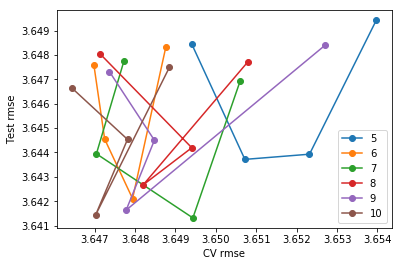

In [132]:
plt.figure()
for i in range(5,11):
    df=df_all2.loc[i]
    df_err=df_all3.loc[i]
    plt.plot(df.ave_cv_error,df.ave_test_error,linestyle='-',marker='o',label=i)
    #plt.errorbar(df.ave_cv_error,df.ave_test_error,xerr=df_err.cv_error)
    plt.ylabel('Test rmse')
    plt.xlabel('CV rmse')
    plt.legend()
    #plt.xlim([3.645,3.655])
    

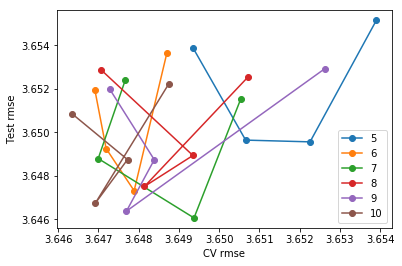

In [136]:
plt.figure()
for i in range(5,11):
    df=df_all2.loc[i]
    df_err=df_all3.loc[i]
    plt.plot(df.cv_error,df.test_error,linestyle='-',marker='o',label=i)
    #plt.errorbar(df.ave_cv_error,df.ave_test_error,xerr=df_err.cv_error)
    plt.ylabel('Test rmse')
    plt.xlabel('CV rmse')
    plt.legend()
    #plt.xlim([3.645,3.655])

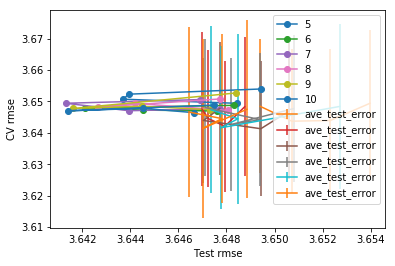

In [130]:
plt.figure()
for i in range(5,11):
    df=df_all2.loc[i]
    df_err=df_all3.loc[i]
    plt.plot(df.ave_test_error,df.ave_cv_error,linestyle='-',marker='o',label=i)
    plt.errorbar(df.ave_cv_error,df.ave_test_error,yerr=df_err.cv_error)
    plt.ylabel('CV rmse')
    plt.xlabel('Test rmse')
    plt.legend()
    #plt.xlim([3.645,3.655])

In [80]:
feat_names[[feats,feats1,feats2,feats3].index(feat)]

'feats1'

In [137]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [139]:
folds = RepeatedStratifiedKFold(n_splits=fold,n_repeats=10, random_state=4950)

In [148]:
def regression2(df_train,df_test,fold,feature):
    results=pd.DataFrame()
    folds = RepeatedStratifiedKFold(n_splits=fold,n_repeats=10,random_state=4950)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
#     predictions_final=np.zeros(len(df_test))
    val_error=[]
    test_error=[]
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):

        # cal the outlier ratio for each fold
        cur_fold= df_train.iloc[trn_idx]
        number_outliers = len(cur_fold[cur_fold['outliers'] == 1])
        total = len(cur_fold)
        print("fold %s %s %s" % (fold_,number_outliers, number_outliers / total))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][feature], label=y_train.target.iloc[trn_idx])
        val_data = lgb.Dataset(df_train.iloc[val_idx][feature], label=y_train.target.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 600)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][feature], num_iteration=clf.best_iteration)
        oof_test=clf.predict(df_test[feature], num_iteration=clf.best_iteration)
        
        val_error.append(np.sqrt(mean_squared_error(oof[val_idx], y_train.target.iloc[val_idx])))
        test_error.append(np.sqrt(mean_squared_error(oof_test, y_test.target)))
        
        predictions += clf.predict(df_test[feature], num_iteration=clf.best_iteration) / (fold*10)
#         clf2=lgb.train(param, df_train[feature], clf.best_iteration, valid_sets = [df_train[feature]], verbose_eval=1000, early_stopping_rounds = 600)
#         predictions_final=clf2.predict(df_test[feature], num_iteration=clf2.best_iteration) / (fold*10)
    
    results['cv_error']=val_error
    results['test_error']=test_error
    results['fold']=[i for i in range(1,fold*10+1,1)]
    results['ave_cv_error']=np.sqrt(mean_squared_error(oof,  y_train.target))
    results['ave_test_error']=np.sqrt(mean_squared_error(predictions, y_test.target))
#     results['ave_test_final_error']=np.sqrt(mean_squared_error(predictions_final, y_test.target))

    return results

In [149]:
feat_names=['feats','feats1','feats2','feats3']
df_all=pd.DataFrame()
for fold in [5,6,7,8,9,10]:
    df_total=pd.DataFrame()
    for feat in [feats,feats1,feats2,feats3]:
        df=regression2(df_train,df_test,fold,feat)
        df['feats']=feat_names[[feats,feats1,feats2,feats3].index(feat)] # indicate feat
        df_total=pd.concat([df_total,df],axis=0) # data frame for each feat
    df_total['num_folds']=fold # indicate fold number
    df_all=pd.concat([df_all,df_total],axis=0) # data frame for each fold
    

fold 0 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25382	valid_1's rmse: 3.6401
[2000]	training's rmse: 3.05411	valid_1's rmse: 3.63989
Early stopping, best iteration is:
[1558]	training's rmse: 3.13498	valid_1's rmse: 3.63827
fold 1 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24485	valid_1's rmse: 3.64559
Early stopping, best iteration is:
[1242]	training's rmse: 3.19237	valid_1's rmse: 3.64491
fold 2 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25833	valid_1's rmse: 3.62849
Early stopping, best iteration is:
[1241]	training's rmse: 3.20539	valid_1's rmse: 3.62829
fold 3 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24222	valid_1's rmse: 3.66644
[2000]	training's rmse: 3.04269	valid_1's rmse: 3.66742
Early st

Early stopping, best iteration is:
[1228]	training's rmse: 3.18936	valid_1's rmse: 3.67277
fold 32 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24793	valid_1's rmse: 3.65652
Early stopping, best iteration is:
[1183]	training's rmse: 3.20891	valid_1's rmse: 3.65575
fold 33 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24684	valid_1's rmse: 3.65335
Early stopping, best iteration is:
[1068]	training's rmse: 3.23163	valid_1's rmse: 3.65295
fold 34 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24392	valid_1's rmse: 3.64919
Early stopping, best iteration is:
[840]	training's rmse: 3.28306	valid_1's rmse: 3.64836
fold 35 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25131	valid_1's rmse: 3.65532
Early stopping, best iter

Early stopping, best iteration is:
[1370]	training's rmse: 3.1908	valid_1's rmse: 3.66763
fold 14 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27523	valid_1's rmse: 3.64185
Early stopping, best iteration is:
[1321]	training's rmse: 3.21101	valid_1's rmse: 3.64044
fold 15 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29007	valid_1's rmse: 3.6196
Early stopping, best iteration is:
[1107]	training's rmse: 3.26823	valid_1's rmse: 3.61887
fold 16 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2641	valid_1's rmse: 3.65431
Early stopping, best iteration is:
[850]	training's rmse: 3.2987	valid_1's rmse: 3.65411
fold 17 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27258	valid_1's rmse: 3.64642
Early stopping, best iteratio

fold 46 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27128	valid_1's rmse: 3.63622
Early stopping, best iteration is:
[1150]	training's rmse: 3.24022	valid_1's rmse: 3.63525
fold 47 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27275	valid_1's rmse: 3.65994
Early stopping, best iteration is:
[1051]	training's rmse: 3.26216	valid_1's rmse: 3.65952
fold 48 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26994	valid_1's rmse: 3.66501
Early stopping, best iteration is:
[1136]	training's rmse: 3.24114	valid_1's rmse: 3.66405
fold 49 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.28903	valid_1's rmse: 3.62654
[2000]	training's rmse: 3.10516	valid_1's rmse: 3.62522
Early stopping, best iteration is:
[1628]	training's rmse: 

Early stopping, best iteration is:
[938]	training's rmse: 3.32237	valid_1's rmse: 3.65564
fold 29 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30177	valid_1's rmse: 3.64473
Early stopping, best iteration is:
[1365]	training's rmse: 3.23432	valid_1's rmse: 3.64459
fold 30 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30868	valid_1's rmse: 3.62009
[2000]	training's rmse: 3.13892	valid_1's rmse: 3.61985
Early stopping, best iteration is:
[1515]	training's rmse: 3.21619	valid_1's rmse: 3.61827
fold 31 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29902	valid_1's rmse: 3.66104
[2000]	training's rmse: 3.12726	valid_1's rmse: 3.66127
Early stopping, best iteration is:
[1426]	training's rmse: 3.21914	valid_1's rmse: 3.6597
fold 32 1413 0.010934247486980275
Training until validation scores 

Early stopping, best iteration is:
[1150]	training's rmse: 3.29271	valid_1's rmse: 3.63279
fold 11 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.3113	valid_1's rmse: 3.65978
[2000]	training's rmse: 3.14576	valid_1's rmse: 3.65927
Early stopping, best iteration is:
[1492]	training's rmse: 3.22314	valid_1's rmse: 3.65786
fold 12 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32768	valid_1's rmse: 3.60961
Early stopping, best iteration is:
[1003]	training's rmse: 3.32703	valid_1's rmse: 3.60953
fold 13 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30725	valid_1's rmse: 3.66331
Early stopping, best iteration is:
[948]	training's rmse: 3.3177	valid_1's rmse: 3.66299
fold 14 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.3

fold 43 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30564	valid_1's rmse: 3.67493
Early stopping, best iteration is:
[1168]	training's rmse: 3.27367	valid_1's rmse: 3.67374
fold 44 1413 0.010934247486980275
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31607	valid_1's rmse: 3.65079
Early stopping, best iteration is:
[727]	training's rmse: 3.3708	valid_1's rmse: 3.6505
fold 45 1412 0.010926678274327722
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30878	valid_1's rmse: 3.66516
Early stopping, best iteration is:
[1021]	training's rmse: 3.30446	valid_1's rmse: 3.66487
fold 46 1413 0.010934332100351322
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31276	valid_1's rmse: 3.63806
Early stopping, best iteration is:
[1269]	training's rmse: 3.2616	valid_1's rmse: 3.63712
fold 47 1413 0.0109342474869

fold 24 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2622	valid_1's rmse: 3.65013
Early stopping, best iteration is:
[975]	training's rmse: 3.26782	valid_1's rmse: 3.64976
fold 25 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25661	valid_1's rmse: 3.66871
[2000]	training's rmse: 3.06436	valid_1's rmse: 3.66942
Early stopping, best iteration is:
[1700]	training's rmse: 3.11641	valid_1's rmse: 3.66799
fold 26 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26709	valid_1's rmse: 3.62457
Early stopping, best iteration is:
[934]	training's rmse: 3.28224	valid_1's rmse: 3.62402
fold 27 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25667	valid_1's rmse: 3.65598
[2000]	training's rmse: 3.06837	valid_1's rmse: 3.6532
Early s

fold 55 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2569	valid_1's rmse: 3.63572
[2000]	training's rmse: 3.05752	valid_1's rmse: 3.63479
Early stopping, best iteration is:
[1631]	training's rmse: 3.12659	valid_1's rmse: 3.6341
fold 56 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.24988	valid_1's rmse: 3.66515
[2000]	training's rmse: 3.05886	valid_1's rmse: 3.66259
Early stopping, best iteration is:
[1776]	training's rmse: 3.09684	valid_1's rmse: 3.66189
fold 57 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25817	valid_1's rmse: 3.6452
Early stopping, best iteration is:
[1167]	training's rmse: 3.22057	valid_1's rmse: 3.64457
fold 58 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25523	valid_1's rmse: 3.67215
Early 

Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27688	valid_1's rmse: 3.66946
Early stopping, best iteration is:
[1278]	training's rmse: 3.22052	valid_1's rmse: 3.66882
fold 26 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29202	valid_1's rmse: 3.61727
Early stopping, best iteration is:
[967]	training's rmse: 3.29936	valid_1's rmse: 3.61708
fold 27 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.28599	valid_1's rmse: 3.64799
[2000]	training's rmse: 3.10718	valid_1's rmse: 3.64795
Early stopping, best iteration is:
[1634]	training's rmse: 3.1682	valid_1's rmse: 3.64638
fold 28 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26809	valid_1's rmse: 3.66807
[2000]	training's rmse: 3.08385	valid_1's rmse: 3.66604
Early stopping, best iteration is:
[183

Early stopping, best iteration is:
[1838]	training's rmse: 3.12641	valid_1's rmse: 3.62595
fold 56 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27362	valid_1's rmse: 3.66331
Early stopping, best iteration is:
[1166]	training's rmse: 3.2402	valid_1's rmse: 3.66291
fold 57 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.28269	valid_1's rmse: 3.64666
[2000]	training's rmse: 3.10275	valid_1's rmse: 3.64614
Early stopping, best iteration is:
[1498]	training's rmse: 3.18785	valid_1's rmse: 3.64477
fold 58 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27908	valid_1's rmse: 3.67932
Early stopping, best iteration is:
[860]	training's rmse: 3.30955	valid_1's rmse: 3.67874
fold 59 1472 0.010935132083320953
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.

fold 27 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31349	valid_1's rmse: 3.64982
Early stopping, best iteration is:
[1132]	training's rmse: 3.28856	valid_1's rmse: 3.64894
fold 28 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30121	valid_1's rmse: 3.66585
Early stopping, best iteration is:
[1105]	training's rmse: 3.28113	valid_1's rmse: 3.66514
fold 29 1472 0.010935132083320953
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31382	valid_1's rmse: 3.64694
Early stopping, best iteration is:
[844]	training's rmse: 3.34552	valid_1's rmse: 3.64624
fold 30 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29822	valid_1's rmse: 3.68065
Early stopping, best iteration is:
[803]	training's rmse: 3.33806	valid_1's rmse: 3.68008
fold 31 1471 0.01092786568

Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32706	valid_1's rmse: 3.6143
[2000]	training's rmse: 3.15903	valid_1's rmse: 3.61383
Early stopping, best iteration is:
[1701]	training's rmse: 3.20538	valid_1's rmse: 3.61178
fold 0 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32947	valid_1's rmse: 3.63003
Early stopping, best iteration is:
[1160]	training's rmse: 3.30037	valid_1's rmse: 3.62929
fold 1 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31705	valid_1's rmse: 3.6649
Early stopping, best iteration is:
[870]	training's rmse: 3.34201	valid_1's rmse: 3.66429
fold 2 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33629	valid_1's rmse: 3.61372
Early stopping, best iteration is:
[1084]	training's rmse: 3.32093	valid_1's rmse: 3.61294
fold 3 1

fold 31 1471 0.010927865686056014
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33051	valid_1's rmse: 3.63612
Early stopping, best iteration is:
[1294]	training's rmse: 3.27709	valid_1's rmse: 3.6354
fold 32 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32703	valid_1's rmse: 3.63006
Early stopping, best iteration is:
[850]	training's rmse: 3.3565	valid_1's rmse: 3.62884
fold 33 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32526	valid_1's rmse: 3.65112
Early stopping, best iteration is:
[1281]	training's rmse: 3.27405	valid_1's rmse: 3.64983
fold 34 1472 0.010935213318376656
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33091	valid_1's rmse: 3.62697
Early stopping, best iteration is:
[1136]	training's rmse: 3.30584	valid_1's rmse: 3.62664
fold 35 1472 0.010935132083

fold 3 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2708	valid_1's rmse: 3.62448
[2000]	training's rmse: 3.07966	valid_1's rmse: 3.62126
Early stopping, best iteration is:
[1932]	training's rmse: 3.09078	valid_1's rmse: 3.62092
fold 4 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25492	valid_1's rmse: 3.6794
Early stopping, best iteration is:
[1177]	training's rmse: 3.21722	valid_1's rmse: 3.67896
fold 5 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26384	valid_1's rmse: 3.66377
Early stopping, best iteration is:
[982]	training's rmse: 3.26784	valid_1's rmse: 3.66321
fold 6 1514 0.010934723887388233
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25585	valid_1's rmse: 3.67649
Early stopping, best iteration is:
[816]	training's rmse: 3.29765	val

fold 34 1514 0.010934723887388233
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26163	valid_1's rmse: 3.65304
[2000]	training's rmse: 3.07339	valid_1's rmse: 3.65173
Early stopping, best iteration is:
[1626]	training's rmse: 3.1378	valid_1's rmse: 3.65051
fold 35 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.25459	valid_1's rmse: 3.6881
Early stopping, best iteration is:
[1080]	training's rmse: 3.2391	valid_1's rmse: 3.68784
fold 36 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26983	valid_1's rmse: 3.63165
Early stopping, best iteration is:
[910]	training's rmse: 3.28954	valid_1's rmse: 3.63116
fold 37 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26688	valid_1's rmse: 3.6253
[2000]	training's rmse: 3.07585	valid_1's rmse: 3.62277
Early sto

[1000]	training's rmse: 3.26034	valid_1's rmse: 3.63544
Early stopping, best iteration is:
[1228]	training's rmse: 3.2121	valid_1's rmse: 3.63457
fold 66 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26787	valid_1's rmse: 3.65004
Early stopping, best iteration is:
[886]	training's rmse: 3.29362	valid_1's rmse: 3.64965
fold 67 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26232	valid_1's rmse: 3.65926
[2000]	training's rmse: 3.0748	valid_1's rmse: 3.65654
Early stopping, best iteration is:
[1709]	training's rmse: 3.12595	valid_1's rmse: 3.65576
fold 68 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26183	valid_1's rmse: 3.67665
Early stopping, best iteration is:
[816]	training's rmse: 3.30585	valid_1's rmse: 3.67555
fold 69 1514 0.010934723887388233
Training until validation scores don't

Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.28799	valid_1's rmse: 3.63936
[2000]	training's rmse: 3.10731	valid_1's rmse: 3.63545
Early stopping, best iteration is:
[1922]	training's rmse: 3.12016	valid_1's rmse: 3.63513
fold 28 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2905	valid_1's rmse: 3.655
Early stopping, best iteration is:
[980]	training's rmse: 3.29459	valid_1's rmse: 3.65482
fold 29 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.28862	valid_1's rmse: 3.65299
Early stopping, best iteration is:
[1373]	training's rmse: 3.21589	valid_1's rmse: 3.65265
fold 30 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29182	valid_1's rmse: 3.64705
Early stopping, best iteration is:
[1313]	training's rmse: 3.23359	valid_1's rmse: 3.64647
fold 31

Early stopping, best iteration is:
[840]	training's rmse: 3.32303	valid_1's rmse: 3.65703
fold 58 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.29487	valid_1's rmse: 3.62843
[2000]	training's rmse: 3.11373	valid_1's rmse: 3.62586
[3000]	training's rmse: 2.96506	valid_1's rmse: 3.6259
Early stopping, best iteration is:
[2578]	training's rmse: 3.02307	valid_1's rmse: 3.62482
fold 59 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.30191	valid_1's rmse: 3.60287
Early stopping, best iteration is:
[1079]	training's rmse: 3.28653	valid_1's rmse: 3.60219
fold 60 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.27673	valid_1's rmse: 3.69069
Early stopping, best iteration is:
[1148]	training's rmse: 3.24617	valid_1's rmse: 3.68975
fold 61 1514 0.01093480286298273
Training until validation scores don'

fold 20 1514 0.010934723887388233
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31454	valid_1's rmse: 3.64033
[2000]	training's rmse: 3.14988	valid_1's rmse: 3.63892
Early stopping, best iteration is:
[1676]	training's rmse: 3.19796	valid_1's rmse: 3.63807
fold 21 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32704	valid_1's rmse: 3.61841
Early stopping, best iteration is:
[1113]	training's rmse: 3.30634	valid_1's rmse: 3.61776
fold 22 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.3189	valid_1's rmse: 3.62571
Early stopping, best iteration is:
[923]	training's rmse: 3.33341	valid_1's rmse: 3.62561
fold 23 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31918	valid_1's rmse: 3.64537
Early stopping, best iteration is:
[968]	training's rmse: 3.32

Early stopping, best iteration is:
[1045]	training's rmse: 3.31249	valid_1's rmse: 3.63514
fold 51 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31833	valid_1's rmse: 3.64815
Early stopping, best iteration is:
[1168]	training's rmse: 3.28733	valid_1's rmse: 3.64786
fold 52 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31955	valid_1's rmse: 3.62352
Early stopping, best iteration is:
[957]	training's rmse: 3.3287	valid_1's rmse: 3.6233
fold 53 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32636	valid_1's rmse: 3.63056
[2000]	training's rmse: 3.16503	valid_1's rmse: 3.63009
Early stopping, best iteration is:
[1784]	training's rmse: 3.19718	valid_1's rmse: 3.62928
fold 54 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.3177	

fold 12 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33488	valid_1's rmse: 3.60276
Early stopping, best iteration is:
[1076]	training's rmse: 3.32106	valid_1's rmse: 3.60215
fold 13 1514 0.010934723887388233
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32634	valid_1's rmse: 3.66069
Early stopping, best iteration is:
[1083]	training's rmse: 3.3112	valid_1's rmse: 3.65968
fold 14 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33352	valid_1's rmse: 3.63676
Early stopping, best iteration is:
[861]	training's rmse: 3.36014	valid_1's rmse: 3.6362
fold 15 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32048	valid_1's rmse: 3.68133
Early stopping, best iteration is:
[1211]	training's rmse: 3.28152	valid_1's rmse: 3.67959
fold 16 1514 0.0109348028629

fold 43 1513 0.010927659328595365
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33535	valid_1's rmse: 3.6191
Early stopping, best iteration is:
[1208]	training's rmse: 3.29914	valid_1's rmse: 3.61793
fold 44 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.31916	valid_1's rmse: 3.67568
Early stopping, best iteration is:
[895]	training's rmse: 3.33922	valid_1's rmse: 3.67478
fold 45 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.32628	valid_1's rmse: 3.661
[2000]	training's rmse: 3.1654	valid_1's rmse: 3.66201
Early stopping, best iteration is:
[1451]	training's rmse: 3.24804	valid_1's rmse: 3.66083
fold 46 1514 0.01093480286298273
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.33334	valid_1's rmse: 3.63958
[2000]	training's rmse: 3.17378	valid_1's rmse: 3.63737
Early stopp

Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26776	valid_1's rmse: 3.64309
[2000]	training's rmse: 3.08103	valid_1's rmse: 3.64257
Early stopping, best iteration is:
[2200]	training's rmse: 3.04654	valid_1's rmse: 3.64226
fold 5 1545 0.010931010817809412
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2747	valid_1's rmse: 3.64269
[2000]	training's rmse: 3.08406	valid_1's rmse: 3.64453
Early stopping, best iteration is:
[1594]	training's rmse: 3.15531	valid_1's rmse: 3.64216
fold 6 1546 0.010938008518345574
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.2567	valid_1's rmse: 3.70841
Early stopping, best iteration is:
[946]	training's rmse: 3.26876	valid_1's rmse: 3.70799
fold 7 1546 0.010937931132068797
Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26703	valid_1's rmse: 3.66615
Early stopping, best iteration is:
[946]	tr

Training until validation scores don't improve for 600 rounds.
[1000]	training's rmse: 3.26947	valid_1's rmse: 3.66094
[2000]	training's rmse: 3.08239	valid_1's rmse: 3.65966
Early stopping, best iteration is:
[1817]	training's rmse: 3.11519	valid_1's rmse: 3.6581
fold 35 1545 0.010931010817809412
Training until validation scores don't improve for 600 rounds.


KeyboardInterrupt: 

In [153]:
df_all2=df_all.groupby(['num_folds','feats']).mean()

In [169]:
df_all.to_csv("repeated_nfold_test_test_size0.2.csv", index=False)

In [155]:
df_all2

cv_error  test_error  fold  ave_cv_error  ave_test_error
num_folds feats                                                           
5         feats   3.651413    3.653991  25.5      3.651607        3.647563
          feats1  3.648304    3.648700  25.5      3.649167        3.642233
          feats2  3.647666    3.649841  25.5      3.650139        3.643590
          feats3  3.646687    3.653300  25.5      3.649614        3.647203
6         feats   3.650098    3.653135  30.5      3.650493        3.647384
          feats1  3.646898    3.647726  30.5      3.648668        3.641631
          feats2  3.646317    3.649622  30.5      3.647735        3.644171
          feats3  3.645892    3.652326  30.5      3.647386        3.646845
7         feats   3.649488    3.652757  35.5      3.649185        3.647471
          feats1  3.645985    3.647593  35.5      3.645658        3.642262
          feats2  3.645547    3.648628  35.5      3.645703        3.643489
          feats3  3.645209    3.651512  35.5      3.644425        3.646339

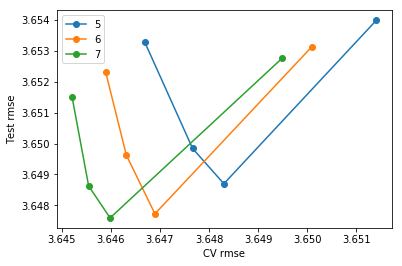

In [154]:
plt.figure()
for i in range(5,8):
    df=df_all2.loc[i]
    #df_err=df_all3.loc[i]
    plt.plot(df.cv_error,df.test_error,linestyle='-',marker='o',label=i)
    #plt.errorbar(df.ave_cv_error,df.ave_test_error,xerr=df_err.cv_error)
    plt.ylabel('Test rmse')
    plt.xlabel('CV rmse')
    plt.legend()
    #plt.xlim([3.645,3.655])

In [162]:
train[feats2].shape

(201917, 91)

## It seems that feat2 is the best for both cv and test . Let's try to submit results for feat2

In [182]:
# 
train_data = lgb.Dataset(train[feats2], label=train.target)
df_submission=pd.DataFrame()
df_summary=pd.DataFrame()
num=[]
for fold in range(5,10):
    cv_score = lgb.cv(param, train_data, 10000, early_stopping_rounds=600, verbose_eval=100,nfold=fold,stratified=False)
    clf=lgb.train(param,train_data,len(cv_score['rmse-mean']), verbose_eval=100)
    predictions=clf.predict(test[feats2],num_iteration=clf.best_iteration)
    df_submission[fold]=predictions
    df_summary[fold]=[cv_score['rmse-mean'],cv_score['rmse-stdv'],len(cv_score['rmse-mean'])]

[100]	cv_agg's rmse: 3.711 + 0.0298158
[200]	cv_agg's rmse: 3.67736 + 0.0282109
[300]	cv_agg's rmse: 3.66458 + 0.0274447
[400]	cv_agg's rmse: 3.65761 + 0.0267827
[500]	cv_agg's rmse: 3.6536 + 0.0259917
[600]	cv_agg's rmse: 3.6512 + 0.0254979
[700]	cv_agg's rmse: 3.64957 + 0.0250862
[800]	cv_agg's rmse: 3.6487 + 0.0248244
[900]	cv_agg's rmse: 3.64811 + 0.024628
[1000]	cv_agg's rmse: 3.64775 + 0.0245095
[1100]	cv_agg's rmse: 3.64784 + 0.0244008
[1200]	cv_agg's rmse: 3.64777 + 0.0243944
[1300]	cv_agg's rmse: 3.64754 + 0.0241296
[1400]	cv_agg's rmse: 3.64744 + 0.0238907
[1500]	cv_agg's rmse: 3.64749 + 0.0236543
[1600]	cv_agg's rmse: 3.64747 + 0.0235358
[1700]	cv_agg's rmse: 3.64732 + 0.0232504
[1800]	cv_agg's rmse: 3.64744 + 0.0231041
[1900]	cv_agg's rmse: 3.64761 + 0.023002
[2000]	cv_agg's rmse: 3.64772 + 0.0226289
[2100]	cv_agg's rmse: 3.64764 + 0.0224156
[2200]	cv_agg's rmse: 3.64799 + 0.0222649
[100]	cv_agg's rmse: 3.70954 + 0.0488879
[200]	cv_agg's rmse: 3.67586 + 0.0460198
[300]	cv_a

In [183]:
df_summary

,5,6,7,8,9
0,"[3.8476860812985243, 3.844774068979722, 3.8420...","[3.847360978754626, 3.8444943178571305, 3.8416...","[3.8475783525511305, 3.8448144871572074, 3.841...","[3.8468864660991016, 3.844097124237644, 3.8413...","[3.847436659729316, 3.8446576711524707, 3.8418..."
1,"[0.031625000601743, 0.031467441634504156, 0.03...","[0.053752643662047864, 0.05382501345169446, 0....","[0.03188243151969365, 0.03177326565063012, 0.0...","[0.07742830382736555, 0.07740921213506777, 0.0...","[0.04762410795972947, 0.04766023124372953, 0.0..."
2,1690,1528,1225,1486,1521


In [212]:
df_summary.iloc[2,:].T

5    1690
6    1528
7    1225
8    1486
9    1521
Name: 2, dtype: object

In [188]:
for i in range(5,10):
    print(min(df_summary.loc[0,i]))

3.6473160701723373
3.644267167356267
3.64573621467503
3.6426146492571756
3.6449329066333984


In [191]:
for i in range(5,10):
    print(sum(df_summary.loc[1,i])/len(df_summary.loc[1,i]))

0.025572451885198293
0.04418199929533809
0.024757300461217435
0.06871544215955824
0.04663307609261487


In [194]:
df_submission['card_id']=test.card_id

In [196]:
df_submission.to_csv("submission_with_different_kfolds.csv",index=False)

In [204]:
df=df_submission[['card_id',5]].copy()
df.columns=['card_id','target']
df.to_csv('submission_5fold_feature_elimination_50.csv',index=False)
#LB:3.681

In [213]:
df=df_submission[['card_id',7]].copy()
df.columns=['card_id','target']
df.to_csv('submission_7fold_feature_elimination_50.csv',index=False)
#LB:3.682

### Data might be to noisy due to outliers. Outliers can drastically effect performance of algorithm. Let's try to train without outliers and see if cv score correlates to test score


In [217]:
feats1=pd.read_csv('threshold_feature_elimination30_8extra_test10_without_outliers.csv',squeeze=True).tolist()
feats2=pd.read_csv('threshold_feature_elimination80_8extra_test10_without_outliers.csv',squeeze=True).tolist()
feats3=pd.read_csv('threshold_feature_elimination95_8extra_test10_without_outliers.csv',squeeze=True).tolist()


In [218]:
len(feats),len(feats1),len(feats2),len(feats3)

(253, 80, 63, 54)

In [238]:
data=pd.read_csv('merchants_map.csv')
df_train=df_train.merge(data,on='card_id')
df_test=df_test.merge(data,on='card_id')

In [239]:
def regression(df_train,df_test,fold,feature):
    results=pd.DataFrame()
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=4950)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    val_error=[]
    test_error=[]
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):

        # cal the outlier ratio for each fold
        cur_fold= df_train.iloc[trn_idx]
        number_outliers = len(cur_fold[cur_fold['outliers'] == 1])
        total = len(cur_fold)
        print("fold %s %s %s" % (fold_,number_outliers, number_outliers / total))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][feature], label=df_train.target.iloc[trn_idx])
        val_data = lgb.Dataset(df_train.iloc[val_idx][feature], label=df_train.target.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 600)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][feature], num_iteration=clf.best_iteration)
        oof_test=clf.predict(df_test[feature], num_iteration=clf.best_iteration)
        
        val_error.append(np.sqrt(mean_squared_error(oof[val_idx], df_train.target.iloc[val_idx])))
        test_error.append(np.sqrt(mean_squared_error(oof_test, df_test.target)))
        
        predictions += clf.predict(df_test[feature], num_iteration=clf.best_iteration) / folds.n_splits
    results['cv_error']=val_error
    results['test_error']=test_error
    results['fold']=[i for i in range(1,fold+1,1)]
    results['ave_cv_error']=np.sqrt(mean_squared_error(oof,  df_train.target))
    results['ave_test_error']=np.sqrt(mean_squared_error(predictions, df_test.target))

    return results

In [240]:
feat_names=['feats','feats1','feats2','feats3']
df_all=pd.DataFrame()
for fold in [5,6,7,8,9,10]:
    df_total=pd.DataFrame()
    for feat in [feats,feats1,feats2,feats3]:
        df=regression(df_train[df_train.outliers==0],df_test[df_test.outliers==0],fold,feat)
        df['feats']=feat_names[[feats,feats1,feats2,feats3].index(feat)] # indicate feat
        df_total=pd.concat([df_total,df],axis=0) # data frame for each feat
    df_total['num_folds']=fold # indicate fold number
    df_all=pd.concat([df_all,df_total],axis=0) # data frame for each fold
    

fold 0 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60681	valid_1's rmse: 1.60474
[200]	training's rmse: 1.57336	valid_1's rmse: 1.57764
[300]	training's rmse: 1.55666	valid_1's rmse: 1.56722
[400]	training's rmse: 1.54499	valid_1's rmse: 1.56178
[500]	training's rmse: 1.5356	valid_1's rmse: 1.55861
[600]	training's rmse: 1.52754	valid_1's rmse: 1.55662
[700]	training's rmse: 1.52027	valid_1's rmse: 1.55535
[800]	training's rmse: 1.51376	valid_1's rmse: 1.55446
[900]	training's rmse: 1.50772	valid_1's rmse: 1.55385
[1000]	training's rmse: 1.50196	valid_1's rmse: 1.55336
[1100]	training's rmse: 1.49637	valid_1's rmse: 1.55303
[1200]	training's rmse: 1.49104	valid_1's rmse: 1.55283
[1300]	training's rmse: 1.4858	valid_1's rmse: 1.55255
[1400]	training's rmse: 1.48064	valid_1's rmse: 1.5524
[1500]	training's rmse: 1.47566	valid_1's rmse: 1.55224
[1600]	training's rmse: 1.47078	valid_1's rmse: 1.5521
[1700]	training's rmse: 1.46593	valid_1's

[3500]	training's rmse: 1.38684	valid_1's rmse: 1.553
[3600]	training's rmse: 1.38282	valid_1's rmse: 1.55303
[3700]	training's rmse: 1.379	valid_1's rmse: 1.55301
[3800]	training's rmse: 1.37503	valid_1's rmse: 1.55307
[3900]	training's rmse: 1.37104	valid_1's rmse: 1.55315
[4000]	training's rmse: 1.36715	valid_1's rmse: 1.55324
[4100]	training's rmse: 1.36318	valid_1's rmse: 1.55326
Early stopping, best iteration is:
[3510]	training's rmse: 1.38646	valid_1's rmse: 1.55298
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60368	valid_1's rmse: 1.61692
[200]	training's rmse: 1.57009	valid_1's rmse: 1.59032
[300]	training's rmse: 1.55333	valid_1's rmse: 1.5807
[400]	training's rmse: 1.54182	valid_1's rmse: 1.57586
[500]	training's rmse: 1.53238	valid_1's rmse: 1.57284
[600]	training's rmse: 1.52419	valid_1's rmse: 1.57097
[700]	training's rmse: 1.51678	valid_1's rmse: 1.5696
[800]	training's rmse: 1.51019	valid_1's rmse: 1.56887
[900]	t

[2400]	training's rmse: 1.45813	valid_1's rmse: 1.54882
[2500]	training's rmse: 1.45462	valid_1's rmse: 1.5488
[2600]	training's rmse: 1.45134	valid_1's rmse: 1.54886
[2700]	training's rmse: 1.44808	valid_1's rmse: 1.54883
[2800]	training's rmse: 1.44474	valid_1's rmse: 1.54882
[2900]	training's rmse: 1.44165	valid_1's rmse: 1.54877
[3000]	training's rmse: 1.4384	valid_1's rmse: 1.54869
[3100]	training's rmse: 1.43517	valid_1's rmse: 1.54865
[3200]	training's rmse: 1.43206	valid_1's rmse: 1.54868
[3300]	training's rmse: 1.42888	valid_1's rmse: 1.54873
[3400]	training's rmse: 1.4256	valid_1's rmse: 1.54877
[3500]	training's rmse: 1.42243	valid_1's rmse: 1.54889
[3600]	training's rmse: 1.41928	valid_1's rmse: 1.54894
Early stopping, best iteration is:
[3093]	training's rmse: 1.4354	valid_1's rmse: 1.54861
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.59974	valid_1's rmse: 1.61359
[200]	training's rmse: 1.56631	valid_1's rmse: 1.58669

[1600]	training's rmse: 1.48988	valid_1's rmse: 1.5509
[1700]	training's rmse: 1.48642	valid_1's rmse: 1.55078
[1800]	training's rmse: 1.48294	valid_1's rmse: 1.55068
[1900]	training's rmse: 1.47942	valid_1's rmse: 1.55063
[2000]	training's rmse: 1.47604	valid_1's rmse: 1.55054
[2100]	training's rmse: 1.47272	valid_1's rmse: 1.5505
[2200]	training's rmse: 1.46936	valid_1's rmse: 1.55052
[2300]	training's rmse: 1.4661	valid_1's rmse: 1.55057
[2400]	training's rmse: 1.46282	valid_1's rmse: 1.55066
[2500]	training's rmse: 1.45947	valid_1's rmse: 1.5507
[2600]	training's rmse: 1.45641	valid_1's rmse: 1.55078
Early stopping, best iteration is:
[2081]	training's rmse: 1.47332	valid_1's rmse: 1.55047
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.59973	valid_1's rmse: 1.61345
[200]	training's rmse: 1.56631	valid_1's rmse: 1.58643
[300]	training's rmse: 1.55093	valid_1's rmse: 1.57681
[400]	training's rmse: 1.54116	valid_1's rmse: 1.57204
[

[1800]	training's rmse: 1.48573	valid_1's rmse: 1.55162
[1900]	training's rmse: 1.4825	valid_1's rmse: 1.5516
[2000]	training's rmse: 1.47905	valid_1's rmse: 1.5516
[2100]	training's rmse: 1.47573	valid_1's rmse: 1.5516
[2200]	training's rmse: 1.4724	valid_1's rmse: 1.55162
[2300]	training's rmse: 1.46915	valid_1's rmse: 1.55151
[2400]	training's rmse: 1.46589	valid_1's rmse: 1.55152
[2500]	training's rmse: 1.46254	valid_1's rmse: 1.55146
[2600]	training's rmse: 1.45938	valid_1's rmse: 1.55153
[2700]	training's rmse: 1.4563	valid_1's rmse: 1.55155
[2800]	training's rmse: 1.45308	valid_1's rmse: 1.55155
[2900]	training's rmse: 1.45013	valid_1's rmse: 1.55162
[3000]	training's rmse: 1.44704	valid_1's rmse: 1.55161
[3100]	training's rmse: 1.444	valid_1's rmse: 1.55162
Early stopping, best iteration is:
[2526]	training's rmse: 1.46172	valid_1's rmse: 1.55143
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.59979	valid_1's rmse: 1.61345
[2

[1200]	training's rmse: 1.49437	valid_1's rmse: 1.54483
[1300]	training's rmse: 1.48927	valid_1's rmse: 1.54457
[1400]	training's rmse: 1.48429	valid_1's rmse: 1.54444
[1500]	training's rmse: 1.47943	valid_1's rmse: 1.54443
[1600]	training's rmse: 1.47464	valid_1's rmse: 1.54436
[1700]	training's rmse: 1.47012	valid_1's rmse: 1.54428
[1800]	training's rmse: 1.46543	valid_1's rmse: 1.54413
[1900]	training's rmse: 1.46093	valid_1's rmse: 1.54425
[2000]	training's rmse: 1.45628	valid_1's rmse: 1.54422
[2100]	training's rmse: 1.45191	valid_1's rmse: 1.54412
[2200]	training's rmse: 1.4475	valid_1's rmse: 1.54409
[2300]	training's rmse: 1.44313	valid_1's rmse: 1.54408
[2400]	training's rmse: 1.43891	valid_1's rmse: 1.54404
[2500]	training's rmse: 1.43466	valid_1's rmse: 1.54402
[2600]	training's rmse: 1.43043	valid_1's rmse: 1.54404
[2700]	training's rmse: 1.42629	valid_1's rmse: 1.5441
[2800]	training's rmse: 1.4222	valid_1's rmse: 1.54406
[2900]	training's rmse: 1.41805	valid_1's rmse: 1.5

[900]	training's rmse: 1.51604	valid_1's rmse: 1.54705
[1000]	training's rmse: 1.51172	valid_1's rmse: 1.54666
[1100]	training's rmse: 1.50767	valid_1's rmse: 1.54645
[1200]	training's rmse: 1.50364	valid_1's rmse: 1.54616
[1300]	training's rmse: 1.49972	valid_1's rmse: 1.54604
[1400]	training's rmse: 1.4959	valid_1's rmse: 1.5459
[1500]	training's rmse: 1.49225	valid_1's rmse: 1.54583
[1600]	training's rmse: 1.48863	valid_1's rmse: 1.54572
[1700]	training's rmse: 1.48504	valid_1's rmse: 1.54561
[1800]	training's rmse: 1.48154	valid_1's rmse: 1.54559
[1900]	training's rmse: 1.47808	valid_1's rmse: 1.54563
[2000]	training's rmse: 1.47469	valid_1's rmse: 1.54564
[2100]	training's rmse: 1.47127	valid_1's rmse: 1.54555
[2200]	training's rmse: 1.46792	valid_1's rmse: 1.54544
[2300]	training's rmse: 1.46453	valid_1's rmse: 1.54544
[2400]	training's rmse: 1.4613	valid_1's rmse: 1.54551
[2500]	training's rmse: 1.45802	valid_1's rmse: 1.54545
[2600]	training's rmse: 1.45482	valid_1's rmse: 1.54

[400]	training's rmse: 1.53926	valid_1's rmse: 1.58802
[500]	training's rmse: 1.53207	valid_1's rmse: 1.58488
[600]	training's rmse: 1.52613	valid_1's rmse: 1.58291
[700]	training's rmse: 1.52088	valid_1's rmse: 1.58161
[800]	training's rmse: 1.51625	valid_1's rmse: 1.58089
[900]	training's rmse: 1.51188	valid_1's rmse: 1.58035
[1000]	training's rmse: 1.5078	valid_1's rmse: 1.58
[1100]	training's rmse: 1.50411	valid_1's rmse: 1.57969
[1200]	training's rmse: 1.5004	valid_1's rmse: 1.57947
[1300]	training's rmse: 1.49681	valid_1's rmse: 1.57928
[1400]	training's rmse: 1.49318	valid_1's rmse: 1.57911
[1500]	training's rmse: 1.4897	valid_1's rmse: 1.5789
[1600]	training's rmse: 1.48623	valid_1's rmse: 1.57884
[1700]	training's rmse: 1.48281	valid_1's rmse: 1.57871
[1800]	training's rmse: 1.47953	valid_1's rmse: 1.57866
[1900]	training's rmse: 1.47623	valid_1's rmse: 1.57867
[2000]	training's rmse: 1.47288	valid_1's rmse: 1.57861
[2100]	training's rmse: 1.46969	valid_1's rmse: 1.57863
[2200

[1300]	training's rmse: 1.50681	valid_1's rmse: 1.53971
[1400]	training's rmse: 1.50342	valid_1's rmse: 1.53953
[1500]	training's rmse: 1.49988	valid_1's rmse: 1.53939
[1600]	training's rmse: 1.49651	valid_1's rmse: 1.53931
[1700]	training's rmse: 1.49319	valid_1's rmse: 1.53935
[1800]	training's rmse: 1.4899	valid_1's rmse: 1.53938
[1900]	training's rmse: 1.48671	valid_1's rmse: 1.53935
[2000]	training's rmse: 1.48355	valid_1's rmse: 1.53937
[2100]	training's rmse: 1.48033	valid_1's rmse: 1.53935
[2200]	training's rmse: 1.47714	valid_1's rmse: 1.53933
[2300]	training's rmse: 1.47407	valid_1's rmse: 1.53931
[2400]	training's rmse: 1.47096	valid_1's rmse: 1.53938
[2500]	training's rmse: 1.46781	valid_1's rmse: 1.53941
[2600]	training's rmse: 1.46469	valid_1's rmse: 1.53946
Early stopping, best iteration is:
[2053]	training's rmse: 1.48189	valid_1's rmse: 1.53926
fold 1 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.597	valid_1's rmse: 1.633

[1000]	training's rmse: 1.51391	valid_1's rmse: 1.56081
[1100]	training's rmse: 1.51021	valid_1's rmse: 1.56043
[1200]	training's rmse: 1.50664	valid_1's rmse: 1.56034
[1300]	training's rmse: 1.50312	valid_1's rmse: 1.56025
[1400]	training's rmse: 1.49975	valid_1's rmse: 1.56019
[1500]	training's rmse: 1.49632	valid_1's rmse: 1.56015
[1600]	training's rmse: 1.49298	valid_1's rmse: 1.56004
[1700]	training's rmse: 1.4897	valid_1's rmse: 1.55992
[1800]	training's rmse: 1.48644	valid_1's rmse: 1.55989
[1900]	training's rmse: 1.48316	valid_1's rmse: 1.55992
[2000]	training's rmse: 1.47975	valid_1's rmse: 1.55993
[2100]	training's rmse: 1.47664	valid_1's rmse: 1.55994
[2200]	training's rmse: 1.47351	valid_1's rmse: 1.55994
[2300]	training's rmse: 1.47033	valid_1's rmse: 1.55993
Early stopping, best iteration is:
[1770]	training's rmse: 1.48743	valid_1's rmse: 1.55983
fold 0 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60842	valid_1's rmse: 1.5

[1300]	training's rmse: 1.48967	valid_1's rmse: 1.54634
[1400]	training's rmse: 1.48475	valid_1's rmse: 1.54618
[1500]	training's rmse: 1.47995	valid_1's rmse: 1.54606
[1600]	training's rmse: 1.47544	valid_1's rmse: 1.54603
[1700]	training's rmse: 1.47072	valid_1's rmse: 1.546
[1800]	training's rmse: 1.46621	valid_1's rmse: 1.54598
[1900]	training's rmse: 1.46172	valid_1's rmse: 1.54584
[2000]	training's rmse: 1.45742	valid_1's rmse: 1.54583
[2100]	training's rmse: 1.45307	valid_1's rmse: 1.5458
[2200]	training's rmse: 1.44877	valid_1's rmse: 1.54577
[2300]	training's rmse: 1.44447	valid_1's rmse: 1.54565
[2400]	training's rmse: 1.4402	valid_1's rmse: 1.54566
[2500]	training's rmse: 1.43609	valid_1's rmse: 1.54562
[2600]	training's rmse: 1.43201	valid_1's rmse: 1.54551
[2700]	training's rmse: 1.42797	valid_1's rmse: 1.54553
[2800]	training's rmse: 1.42395	valid_1's rmse: 1.54547
[2900]	training's rmse: 1.41993	valid_1's rmse: 1.54548
[3000]	training's rmse: 1.41586	valid_1's rmse: 1.54

[1900]	training's rmse: 1.48101	valid_1's rmse: 1.54
[2000]	training's rmse: 1.4776	valid_1's rmse: 1.54009
[2100]	training's rmse: 1.47422	valid_1's rmse: 1.53996
[2200]	training's rmse: 1.47098	valid_1's rmse: 1.53996
[2300]	training's rmse: 1.46761	valid_1's rmse: 1.54001
[2400]	training's rmse: 1.46431	valid_1's rmse: 1.54022
[2500]	training's rmse: 1.46107	valid_1's rmse: 1.54026
[2600]	training's rmse: 1.45788	valid_1's rmse: 1.54026
[2700]	training's rmse: 1.45452	valid_1's rmse: 1.54023
[2800]	training's rmse: 1.45142	valid_1's rmse: 1.54023
Early stopping, best iteration is:
[2239]	training's rmse: 1.46968	valid_1's rmse: 1.53988
fold 1 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.59933	valid_1's rmse: 1.62488
[200]	training's rmse: 1.56645	valid_1's rmse: 1.5954
[300]	training's rmse: 1.55118	valid_1's rmse: 1.58383
[400]	training's rmse: 1.54134	valid_1's rmse: 1.57817
[500]	training's rmse: 1.53385	valid_1's rmse: 1.57475
[60

[500]	training's rmse: 1.53633	valid_1's rmse: 1.56192
[600]	training's rmse: 1.53025	valid_1's rmse: 1.56003
[700]	training's rmse: 1.52494	valid_1's rmse: 1.55874
[800]	training's rmse: 1.52027	valid_1's rmse: 1.55794
[900]	training's rmse: 1.51582	valid_1's rmse: 1.55731
[1000]	training's rmse: 1.51166	valid_1's rmse: 1.55678
[1100]	training's rmse: 1.50769	valid_1's rmse: 1.5564
[1200]	training's rmse: 1.50375	valid_1's rmse: 1.55607
[1300]	training's rmse: 1.49996	valid_1's rmse: 1.55576
[1400]	training's rmse: 1.4962	valid_1's rmse: 1.5557
[1500]	training's rmse: 1.49258	valid_1's rmse: 1.55552
[1600]	training's rmse: 1.48914	valid_1's rmse: 1.55541
[1700]	training's rmse: 1.48567	valid_1's rmse: 1.5554
[1800]	training's rmse: 1.48211	valid_1's rmse: 1.55541
[1900]	training's rmse: 1.47871	valid_1's rmse: 1.55545
[2000]	training's rmse: 1.47527	valid_1's rmse: 1.55543
[2100]	training's rmse: 1.47187	valid_1's rmse: 1.55545
[2200]	training's rmse: 1.4686	valid_1's rmse: 1.55545
[2

[500]	training's rmse: 1.53899	valid_1's rmse: 1.54684
[600]	training's rmse: 1.53296	valid_1's rmse: 1.54547
[700]	training's rmse: 1.52781	valid_1's rmse: 1.54474
[800]	training's rmse: 1.52328	valid_1's rmse: 1.54432
[900]	training's rmse: 1.51917	valid_1's rmse: 1.54416
[1000]	training's rmse: 1.51525	valid_1's rmse: 1.54399
[1100]	training's rmse: 1.51139	valid_1's rmse: 1.54394
[1200]	training's rmse: 1.50761	valid_1's rmse: 1.54375
[1300]	training's rmse: 1.50409	valid_1's rmse: 1.54375
[1400]	training's rmse: 1.50061	valid_1's rmse: 1.54371
[1500]	training's rmse: 1.4972	valid_1's rmse: 1.54378
[1600]	training's rmse: 1.49391	valid_1's rmse: 1.54377
[1700]	training's rmse: 1.49051	valid_1's rmse: 1.54377
[1800]	training's rmse: 1.48727	valid_1's rmse: 1.54385
[1900]	training's rmse: 1.48385	valid_1's rmse: 1.54388
Early stopping, best iteration is:
[1378]	training's rmse: 1.50136	valid_1's rmse: 1.54369
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.

[1800]	training's rmse: 1.48633	valid_1's rmse: 1.56989
[1900]	training's rmse: 1.48329	valid_1's rmse: 1.56984
[2000]	training's rmse: 1.48011	valid_1's rmse: 1.56975
[2100]	training's rmse: 1.47686	valid_1's rmse: 1.56963
[2200]	training's rmse: 1.47381	valid_1's rmse: 1.56965
[2300]	training's rmse: 1.47067	valid_1's rmse: 1.56965
[2400]	training's rmse: 1.46764	valid_1's rmse: 1.56966
[2500]	training's rmse: 1.46459	valid_1's rmse: 1.56977
[2600]	training's rmse: 1.46166	valid_1's rmse: 1.56976
[2700]	training's rmse: 1.45879	valid_1's rmse: 1.56979
[2800]	training's rmse: 1.45579	valid_1's rmse: 1.56988
Early stopping, best iteration is:
[2241]	training's rmse: 1.47251	valid_1's rmse: 1.5696
fold 2 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60112	valid_1's rmse: 1.61341
[200]	training's rmse: 1.56839	valid_1's rmse: 1.58558
[300]	training's rmse: 1.55337	valid_1's rmse: 1.57452
[400]	training's rmse: 1.54394	valid_1's rmse: 1.5687

[2400]	training's rmse: 1.46855	valid_1's rmse: 1.56134
[2500]	training's rmse: 1.46561	valid_1's rmse: 1.56142
[2600]	training's rmse: 1.46264	valid_1's rmse: 1.56156
[2700]	training's rmse: 1.45958	valid_1's rmse: 1.56169
Early stopping, best iteration is:
[2180]	training's rmse: 1.47519	valid_1's rmse: 1.56117
fold 0 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60814	valid_1's rmse: 1.59359
[200]	training's rmse: 1.57515	valid_1's rmse: 1.56711
[300]	training's rmse: 1.55886	valid_1's rmse: 1.55708
[400]	training's rmse: 1.54774	valid_1's rmse: 1.55229
[500]	training's rmse: 1.53869	valid_1's rmse: 1.54943
[600]	training's rmse: 1.53108	valid_1's rmse: 1.54752
[700]	training's rmse: 1.52423	valid_1's rmse: 1.54632
[800]	training's rmse: 1.51812	valid_1's rmse: 1.54565
[900]	training's rmse: 1.51247	valid_1's rmse: 1.54489
[1000]	training's rmse: 1.507	valid_1's rmse: 1.54439
[1100]	training's rmse: 1.50182	valid_1's rmse: 1.54404
[120

[3000]	training's rmse: 1.41966	valid_1's rmse: 1.54285
[3100]	training's rmse: 1.4157	valid_1's rmse: 1.54286
[3200]	training's rmse: 1.4118	valid_1's rmse: 1.54291
[3300]	training's rmse: 1.40787	valid_1's rmse: 1.54304
Early stopping, best iteration is:
[2757]	training's rmse: 1.42915	valid_1's rmse: 1.54269
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60728	valid_1's rmse: 1.59993
[200]	training's rmse: 1.57417	valid_1's rmse: 1.57345
[300]	training's rmse: 1.55778	valid_1's rmse: 1.56344
[400]	training's rmse: 1.5466	valid_1's rmse: 1.5585
[500]	training's rmse: 1.53751	valid_1's rmse: 1.55552
[600]	training's rmse: 1.52976	valid_1's rmse: 1.55383
[700]	training's rmse: 1.52289	valid_1's rmse: 1.55276
[800]	training's rmse: 1.51665	valid_1's rmse: 1.55192
[900]	training's rmse: 1.5109	valid_1's rmse: 1.55156
[1000]	training's rmse: 1.50547	valid_1's rmse: 1.55136
[1100]	training's rmse: 1.50033	valid_1's rmse: 1.55108
[1200]	

[500]	training's rmse: 1.53888	valid_1's rmse: 1.54392
[600]	training's rmse: 1.53279	valid_1's rmse: 1.5426
[700]	training's rmse: 1.5275	valid_1's rmse: 1.54156
[800]	training's rmse: 1.52282	valid_1's rmse: 1.54097
[900]	training's rmse: 1.51851	valid_1's rmse: 1.54074
[1000]	training's rmse: 1.5144	valid_1's rmse: 1.5405
[1100]	training's rmse: 1.51033	valid_1's rmse: 1.54041
[1200]	training's rmse: 1.50638	valid_1's rmse: 1.54025
[1300]	training's rmse: 1.50266	valid_1's rmse: 1.54016
[1400]	training's rmse: 1.49901	valid_1's rmse: 1.54002
[1500]	training's rmse: 1.49543	valid_1's rmse: 1.54001
[1600]	training's rmse: 1.49179	valid_1's rmse: 1.5401
[1700]	training's rmse: 1.48837	valid_1's rmse: 1.54006
[1800]	training's rmse: 1.48493	valid_1's rmse: 1.54
[1900]	training's rmse: 1.48148	valid_1's rmse: 1.53994
[2000]	training's rmse: 1.47821	valid_1's rmse: 1.53996
[2100]	training's rmse: 1.47501	valid_1's rmse: 1.53998
[2200]	training's rmse: 1.47175	valid_1's rmse: 1.54013
[2300

[1700]	training's rmse: 1.48721	valid_1's rmse: 1.54676
[1800]	training's rmse: 1.48377	valid_1's rmse: 1.54684
[1900]	training's rmse: 1.48037	valid_1's rmse: 1.54689
[2000]	training's rmse: 1.47709	valid_1's rmse: 1.54677
[2100]	training's rmse: 1.4738	valid_1's rmse: 1.54675
[2200]	training's rmse: 1.47058	valid_1's rmse: 1.54685
[2300]	training's rmse: 1.46738	valid_1's rmse: 1.54689
[2400]	training's rmse: 1.46407	valid_1's rmse: 1.5469
[2500]	training's rmse: 1.46094	valid_1's rmse: 1.54699
[2600]	training's rmse: 1.45774	valid_1's rmse: 1.54701
Early stopping, best iteration is:
[2078]	training's rmse: 1.47452	valid_1's rmse: 1.54668
fold 5 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.6022	valid_1's rmse: 1.6075
[200]	training's rmse: 1.56949	valid_1's rmse: 1.57742
[300]	training's rmse: 1.55441	valid_1's rmse: 1.56566
[400]	training's rmse: 1.54459	valid_1's rmse: 1.55941
[500]	training's rmse: 1.53738	valid_1's rmse: 1.55575
[6

[1900]	training's rmse: 1.4824	valid_1's rmse: 1.56456
[2000]	training's rmse: 1.47929	valid_1's rmse: 1.56445
[2100]	training's rmse: 1.47624	valid_1's rmse: 1.56445
[2200]	training's rmse: 1.47309	valid_1's rmse: 1.56441
[2300]	training's rmse: 1.47005	valid_1's rmse: 1.56446
[2400]	training's rmse: 1.467	valid_1's rmse: 1.56446
[2500]	training's rmse: 1.46394	valid_1's rmse: 1.5644
[2600]	training's rmse: 1.46092	valid_1's rmse: 1.56438
[2700]	training's rmse: 1.45799	valid_1's rmse: 1.56448
[2800]	training's rmse: 1.4551	valid_1's rmse: 1.56451
[2900]	training's rmse: 1.45216	valid_1's rmse: 1.56453
[3000]	training's rmse: 1.44923	valid_1's rmse: 1.56463
[3100]	training's rmse: 1.44633	valid_1's rmse: 1.56454
Early stopping, best iteration is:
[2568]	training's rmse: 1.46191	valid_1's rmse: 1.56436
fold 2 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.59959	valid_1's rmse: 1.62598
[200]	training's rmse: 1.56699	valid_1's rmse: 1.59676


[1700]	training's rmse: 1.48948	valid_1's rmse: 1.56434
[1800]	training's rmse: 1.48617	valid_1's rmse: 1.56421
[1900]	training's rmse: 1.4828	valid_1's rmse: 1.56419
[2000]	training's rmse: 1.47969	valid_1's rmse: 1.56404
[2100]	training's rmse: 1.47659	valid_1's rmse: 1.56412
[2200]	training's rmse: 1.47339	valid_1's rmse: 1.5641
[2300]	training's rmse: 1.47024	valid_1's rmse: 1.56407
[2400]	training's rmse: 1.46728	valid_1's rmse: 1.56422
[2500]	training's rmse: 1.4643	valid_1's rmse: 1.56429
[2600]	training's rmse: 1.46136	valid_1's rmse: 1.56427
Early stopping, best iteration is:
[2001]	training's rmse: 1.47965	valid_1's rmse: 1.56403
fold 7 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60182	valid_1's rmse: 1.60805
[200]	training's rmse: 1.56852	valid_1's rmse: 1.58176
[300]	training's rmse: 1.55326	valid_1's rmse: 1.57261
[400]	training's rmse: 1.54362	valid_1's rmse: 1.56818
[500]	training's rmse: 1.53639	valid_1's rmse: 1.56589
[

[1300]	training's rmse: 1.50699	valid_1's rmse: 1.54134
[1400]	training's rmse: 1.50371	valid_1's rmse: 1.54123
[1500]	training's rmse: 1.50038	valid_1's rmse: 1.54118
[1600]	training's rmse: 1.49711	valid_1's rmse: 1.54116
[1700]	training's rmse: 1.49387	valid_1's rmse: 1.54112
[1800]	training's rmse: 1.49079	valid_1's rmse: 1.54115
[1900]	training's rmse: 1.48773	valid_1's rmse: 1.5412
[2000]	training's rmse: 1.48472	valid_1's rmse: 1.54114
[2100]	training's rmse: 1.48163	valid_1's rmse: 1.54117
[2200]	training's rmse: 1.47872	valid_1's rmse: 1.54116
[2300]	training's rmse: 1.4758	valid_1's rmse: 1.54122
Early stopping, best iteration is:
[1703]	training's rmse: 1.49379	valid_1's rmse: 1.54111
fold 4 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60368	valid_1's rmse: 1.59606
[200]	training's rmse: 1.57075	valid_1's rmse: 1.56854
[300]	training's rmse: 1.55567	valid_1's rmse: 1.55829
[400]	training's rmse: 1.54627	valid_1's rmse: 1.55364

[1600]	training's rmse: 1.47823	valid_1's rmse: 1.54419
[1700]	training's rmse: 1.4737	valid_1's rmse: 1.54412
[1800]	training's rmse: 1.4692	valid_1's rmse: 1.54402
[1900]	training's rmse: 1.46483	valid_1's rmse: 1.5438
[2000]	training's rmse: 1.46059	valid_1's rmse: 1.54371
[2100]	training's rmse: 1.45645	valid_1's rmse: 1.54374
[2200]	training's rmse: 1.4524	valid_1's rmse: 1.54359
[2300]	training's rmse: 1.44826	valid_1's rmse: 1.54353
[2400]	training's rmse: 1.44439	valid_1's rmse: 1.54345
[2500]	training's rmse: 1.44023	valid_1's rmse: 1.54347
[2600]	training's rmse: 1.43625	valid_1's rmse: 1.54351
[2700]	training's rmse: 1.43227	valid_1's rmse: 1.5434
[2800]	training's rmse: 1.42829	valid_1's rmse: 1.54338
[2900]	training's rmse: 1.42435	valid_1's rmse: 1.54324
[3000]	training's rmse: 1.42045	valid_1's rmse: 1.54328
[3100]	training's rmse: 1.41662	valid_1's rmse: 1.54323
[3200]	training's rmse: 1.4128	valid_1's rmse: 1.54333
[3300]	training's rmse: 1.40903	valid_1's rmse: 1.5434

[100]	training's rmse: 1.60747	valid_1's rmse: 1.599
[200]	training's rmse: 1.57459	valid_1's rmse: 1.57105
[300]	training's rmse: 1.55848	valid_1's rmse: 1.56063
[400]	training's rmse: 1.54732	valid_1's rmse: 1.55546
[500]	training's rmse: 1.53836	valid_1's rmse: 1.55255
[600]	training's rmse: 1.53071	valid_1's rmse: 1.55069
[700]	training's rmse: 1.524	valid_1's rmse: 1.54955
[800]	training's rmse: 1.51784	valid_1's rmse: 1.54902
[900]	training's rmse: 1.5121	valid_1's rmse: 1.54846
[1000]	training's rmse: 1.50678	valid_1's rmse: 1.54802
[1100]	training's rmse: 1.50158	valid_1's rmse: 1.54767
[1200]	training's rmse: 1.49663	valid_1's rmse: 1.54738
[1300]	training's rmse: 1.49179	valid_1's rmse: 1.54716
[1400]	training's rmse: 1.48707	valid_1's rmse: 1.54704
[1500]	training's rmse: 1.48234	valid_1's rmse: 1.54693
[1600]	training's rmse: 1.47774	valid_1's rmse: 1.54687
[1700]	training's rmse: 1.47329	valid_1's rmse: 1.5467
[1800]	training's rmse: 1.46891	valid_1's rmse: 1.54661
[1900]	

[1400]	training's rmse: 1.49915	valid_1's rmse: 1.54155
[1500]	training's rmse: 1.49558	valid_1's rmse: 1.54152
[1600]	training's rmse: 1.49201	valid_1's rmse: 1.54139
[1700]	training's rmse: 1.48853	valid_1's rmse: 1.54134
[1800]	training's rmse: 1.48516	valid_1's rmse: 1.54148
[1900]	training's rmse: 1.48188	valid_1's rmse: 1.54145
[2000]	training's rmse: 1.47851	valid_1's rmse: 1.54137
[2100]	training's rmse: 1.47526	valid_1's rmse: 1.54147
[2200]	training's rmse: 1.47198	valid_1's rmse: 1.54151
[2300]	training's rmse: 1.46869	valid_1's rmse: 1.54151
[2400]	training's rmse: 1.46559	valid_1's rmse: 1.54161
[2500]	training's rmse: 1.46253	valid_1's rmse: 1.54167
[2600]	training's rmse: 1.45953	valid_1's rmse: 1.54174
Early stopping, best iteration is:
[2042]	training's rmse: 1.4772	valid_1's rmse: 1.54131
fold 1 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60237	valid_1's rmse: 1.60666
[200]	training's rmse: 1.56955	valid_1's rmse: 1.57

[1200]	training's rmse: 1.50661	valid_1's rmse: 1.54205
[1300]	training's rmse: 1.503	valid_1's rmse: 1.54203
[1400]	training's rmse: 1.49944	valid_1's rmse: 1.54182
[1500]	training's rmse: 1.49594	valid_1's rmse: 1.54164
[1600]	training's rmse: 1.4923	valid_1's rmse: 1.54159
[1700]	training's rmse: 1.48891	valid_1's rmse: 1.54154
[1800]	training's rmse: 1.48551	valid_1's rmse: 1.54155
[1900]	training's rmse: 1.48223	valid_1's rmse: 1.54144
[2000]	training's rmse: 1.47883	valid_1's rmse: 1.54155
[2100]	training's rmse: 1.47545	valid_1's rmse: 1.54127
[2200]	training's rmse: 1.4721	valid_1's rmse: 1.54142
[2300]	training's rmse: 1.46898	valid_1's rmse: 1.54143
[2400]	training's rmse: 1.46592	valid_1's rmse: 1.54141
[2500]	training's rmse: 1.46283	valid_1's rmse: 1.54131
[2600]	training's rmse: 1.45968	valid_1's rmse: 1.54139
[2700]	training's rmse: 1.45651	valid_1's rmse: 1.54142
Early stopping, best iteration is:
[2117]	training's rmse: 1.47487	valid_1's rmse: 1.54123
fold 6 0 0.0
Trai

[200]	training's rmse: 1.56962	valid_1's rmse: 1.57799
[300]	training's rmse: 1.55463	valid_1's rmse: 1.56676
[400]	training's rmse: 1.54513	valid_1's rmse: 1.56108
[500]	training's rmse: 1.53808	valid_1's rmse: 1.55803
[600]	training's rmse: 1.53235	valid_1's rmse: 1.55613
[700]	training's rmse: 1.5274	valid_1's rmse: 1.55506
[800]	training's rmse: 1.52301	valid_1's rmse: 1.55433
[900]	training's rmse: 1.51895	valid_1's rmse: 1.5538
[1000]	training's rmse: 1.51516	valid_1's rmse: 1.55357
[1100]	training's rmse: 1.51147	valid_1's rmse: 1.55324
[1200]	training's rmse: 1.50799	valid_1's rmse: 1.55309
[1300]	training's rmse: 1.50454	valid_1's rmse: 1.55294
[1400]	training's rmse: 1.50115	valid_1's rmse: 1.55286
[1500]	training's rmse: 1.49781	valid_1's rmse: 1.55275
[1600]	training's rmse: 1.49451	valid_1's rmse: 1.55273
[1700]	training's rmse: 1.49126	valid_1's rmse: 1.5526
[1800]	training's rmse: 1.48804	valid_1's rmse: 1.55262
[1900]	training's rmse: 1.4848	valid_1's rmse: 1.55253
[200

[400]	training's rmse: 1.54319	valid_1's rmse: 1.57876
[500]	training's rmse: 1.53614	valid_1's rmse: 1.57518
[600]	training's rmse: 1.53042	valid_1's rmse: 1.57299
[700]	training's rmse: 1.52547	valid_1's rmse: 1.57165
[800]	training's rmse: 1.52109	valid_1's rmse: 1.57097
[900]	training's rmse: 1.51695	valid_1's rmse: 1.57047
[1000]	training's rmse: 1.51314	valid_1's rmse: 1.57006
[1100]	training's rmse: 1.50957	valid_1's rmse: 1.56968
[1200]	training's rmse: 1.50601	valid_1's rmse: 1.56954
[1300]	training's rmse: 1.50252	valid_1's rmse: 1.56925
[1400]	training's rmse: 1.49917	valid_1's rmse: 1.56909
[1500]	training's rmse: 1.49589	valid_1's rmse: 1.56888
[1600]	training's rmse: 1.49256	valid_1's rmse: 1.56868
[1700]	training's rmse: 1.48938	valid_1's rmse: 1.56874
[1800]	training's rmse: 1.48604	valid_1's rmse: 1.56859
[1900]	training's rmse: 1.48285	valid_1's rmse: 1.56851
[2000]	training's rmse: 1.47978	valid_1's rmse: 1.56853
[2100]	training's rmse: 1.47661	valid_1's rmse: 1.5686

[900]	training's rmse: 1.51724	valid_1's rmse: 1.58183
[1000]	training's rmse: 1.51342	valid_1's rmse: 1.58135
[1100]	training's rmse: 1.5099	valid_1's rmse: 1.58102
[1200]	training's rmse: 1.50645	valid_1's rmse: 1.58064
[1300]	training's rmse: 1.50317	valid_1's rmse: 1.58043
[1400]	training's rmse: 1.49988	valid_1's rmse: 1.58024
[1500]	training's rmse: 1.49673	valid_1's rmse: 1.58008
[1600]	training's rmse: 1.49348	valid_1's rmse: 1.57996
[1700]	training's rmse: 1.49033	valid_1's rmse: 1.57979
[1800]	training's rmse: 1.48705	valid_1's rmse: 1.57966
[1900]	training's rmse: 1.48387	valid_1's rmse: 1.57958
[2000]	training's rmse: 1.48095	valid_1's rmse: 1.57945
[2100]	training's rmse: 1.47784	valid_1's rmse: 1.57955
[2200]	training's rmse: 1.47473	valid_1's rmse: 1.57953
[2300]	training's rmse: 1.47183	valid_1's rmse: 1.57951
[2400]	training's rmse: 1.46886	valid_1's rmse: 1.57949
[2500]	training's rmse: 1.46593	valid_1's rmse: 1.57941
[2600]	training's rmse: 1.46319	valid_1's rmse: 1.

[300]	training's rmse: 1.55319	valid_1's rmse: 1.58245
[400]	training's rmse: 1.54386	valid_1's rmse: 1.57679
[500]	training's rmse: 1.53714	valid_1's rmse: 1.5736
[600]	training's rmse: 1.53166	valid_1's rmse: 1.57167
[700]	training's rmse: 1.52689	valid_1's rmse: 1.57046
[800]	training's rmse: 1.52278	valid_1's rmse: 1.56956
[900]	training's rmse: 1.51886	valid_1's rmse: 1.56902
[1000]	training's rmse: 1.51514	valid_1's rmse: 1.56872
[1100]	training's rmse: 1.51168	valid_1's rmse: 1.56834
[1200]	training's rmse: 1.50812	valid_1's rmse: 1.56816
[1300]	training's rmse: 1.50476	valid_1's rmse: 1.56791
[1400]	training's rmse: 1.50145	valid_1's rmse: 1.56785
[1500]	training's rmse: 1.49838	valid_1's rmse: 1.56772
[1600]	training's rmse: 1.49508	valid_1's rmse: 1.56759
[1700]	training's rmse: 1.49194	valid_1's rmse: 1.56754
[1800]	training's rmse: 1.48893	valid_1's rmse: 1.56746
[1900]	training's rmse: 1.48579	valid_1's rmse: 1.56739
[2000]	training's rmse: 1.48263	valid_1's rmse: 1.56734


[1300]	training's rmse: 1.48959	valid_1's rmse: 1.57044
[1400]	training's rmse: 1.48498	valid_1's rmse: 1.57031
[1500]	training's rmse: 1.4804	valid_1's rmse: 1.57011
[1600]	training's rmse: 1.47592	valid_1's rmse: 1.56992
[1700]	training's rmse: 1.4715	valid_1's rmse: 1.56984
[1800]	training's rmse: 1.4673	valid_1's rmse: 1.5696
[1900]	training's rmse: 1.46299	valid_1's rmse: 1.56957
[2000]	training's rmse: 1.45873	valid_1's rmse: 1.56958
[2100]	training's rmse: 1.45449	valid_1's rmse: 1.56945
[2200]	training's rmse: 1.45035	valid_1's rmse: 1.5695
[2300]	training's rmse: 1.44628	valid_1's rmse: 1.56947
[2400]	training's rmse: 1.44236	valid_1's rmse: 1.56945
[2500]	training's rmse: 1.43833	valid_1's rmse: 1.56943
[2600]	training's rmse: 1.43438	valid_1's rmse: 1.56933
[2700]	training's rmse: 1.43036	valid_1's rmse: 1.5692
[2800]	training's rmse: 1.42635	valid_1's rmse: 1.56921
[2900]	training's rmse: 1.42255	valid_1's rmse: 1.56916
[3000]	training's rmse: 1.41881	valid_1's rmse: 1.5691

[2200]	training's rmse: 1.45144	valid_1's rmse: 1.55504
[2300]	training's rmse: 1.4474	valid_1's rmse: 1.55493
[2400]	training's rmse: 1.44327	valid_1's rmse: 1.55492
[2500]	training's rmse: 1.43933	valid_1's rmse: 1.55489
[2600]	training's rmse: 1.43533	valid_1's rmse: 1.55491
[2700]	training's rmse: 1.43142	valid_1's rmse: 1.55484
[2800]	training's rmse: 1.42745	valid_1's rmse: 1.55489
[2900]	training's rmse: 1.42352	valid_1's rmse: 1.55481
[3000]	training's rmse: 1.41958	valid_1's rmse: 1.55487
[3100]	training's rmse: 1.41577	valid_1's rmse: 1.55483
[3200]	training's rmse: 1.41189	valid_1's rmse: 1.55499
[3300]	training's rmse: 1.40816	valid_1's rmse: 1.55504
[3400]	training's rmse: 1.40437	valid_1's rmse: 1.55498
[3500]	training's rmse: 1.40064	valid_1's rmse: 1.55513
Early stopping, best iteration is:
[2938]	training's rmse: 1.42197	valid_1's rmse: 1.55479
fold 7 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60606	valid_1's rmse: 1.6

[1400]	training's rmse: 1.4988	valid_1's rmse: 1.55335
[1500]	training's rmse: 1.49528	valid_1's rmse: 1.55325
[1600]	training's rmse: 1.49178	valid_1's rmse: 1.55319
[1700]	training's rmse: 1.48835	valid_1's rmse: 1.55319
[1800]	training's rmse: 1.48485	valid_1's rmse: 1.55318
[1900]	training's rmse: 1.48151	valid_1's rmse: 1.55312
[2000]	training's rmse: 1.47817	valid_1's rmse: 1.55312
[2100]	training's rmse: 1.47483	valid_1's rmse: 1.55295
[2200]	training's rmse: 1.47164	valid_1's rmse: 1.55293
[2300]	training's rmse: 1.46849	valid_1's rmse: 1.5529
[2400]	training's rmse: 1.46532	valid_1's rmse: 1.55305
[2500]	training's rmse: 1.46219	valid_1's rmse: 1.55302
[2600]	training's rmse: 1.45907	valid_1's rmse: 1.55297
[2700]	training's rmse: 1.45606	valid_1's rmse: 1.55303
[2800]	training's rmse: 1.45291	valid_1's rmse: 1.55306
Early stopping, best iteration is:
[2250]	training's rmse: 1.47003	valid_1's rmse: 1.55283
fold 2 0 0.0
Training until validation scores don't improve for 600 rou

[1300]	training's rmse: 1.50191	valid_1's rmse: 1.55002
[1400]	training's rmse: 1.49832	valid_1's rmse: 1.55003
[1500]	training's rmse: 1.49488	valid_1's rmse: 1.55011
[1600]	training's rmse: 1.4914	valid_1's rmse: 1.54998
[1700]	training's rmse: 1.48809	valid_1's rmse: 1.5501
[1800]	training's rmse: 1.4846	valid_1's rmse: 1.55016
[1900]	training's rmse: 1.48129	valid_1's rmse: 1.55009
[2000]	training's rmse: 1.47799	valid_1's rmse: 1.55011
[2100]	training's rmse: 1.47473	valid_1's rmse: 1.55018
[2200]	training's rmse: 1.4715	valid_1's rmse: 1.55024
Early stopping, best iteration is:
[1618]	training's rmse: 1.49083	valid_1's rmse: 1.54992
fold 6 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60255	valid_1's rmse: 1.60618
[200]	training's rmse: 1.56964	valid_1's rmse: 1.57733
[300]	training's rmse: 1.55454	valid_1's rmse: 1.56615
[400]	training's rmse: 1.54477	valid_1's rmse: 1.56074
[500]	training's rmse: 1.53753	valid_1's rmse: 1.55735
[6

[1200]	training's rmse: 1.50884	valid_1's rmse: 1.54662
[1300]	training's rmse: 1.50534	valid_1's rmse: 1.5466
[1400]	training's rmse: 1.50197	valid_1's rmse: 1.54649
[1500]	training's rmse: 1.49868	valid_1's rmse: 1.54625
[1600]	training's rmse: 1.49547	valid_1's rmse: 1.54608
[1700]	training's rmse: 1.49221	valid_1's rmse: 1.54591
[1800]	training's rmse: 1.48899	valid_1's rmse: 1.5458
[1900]	training's rmse: 1.48584	valid_1's rmse: 1.54572
[2000]	training's rmse: 1.48282	valid_1's rmse: 1.5456
[2100]	training's rmse: 1.4798	valid_1's rmse: 1.54561
[2200]	training's rmse: 1.47671	valid_1's rmse: 1.54573
[2300]	training's rmse: 1.47367	valid_1's rmse: 1.54584
[2400]	training's rmse: 1.47067	valid_1's rmse: 1.54569
[2500]	training's rmse: 1.46772	valid_1's rmse: 1.5457
[2600]	training's rmse: 1.4648	valid_1's rmse: 1.54568
Early stopping, best iteration is:
[2051]	training's rmse: 1.48126	valid_1's rmse: 1.54556
fold 1 0 0.0
Training until validation scores don't improve for 600 rounds.

[200]	training's rmse: 1.57036	valid_1's rmse: 1.5703
[300]	training's rmse: 1.55533	valid_1's rmse: 1.56044
[400]	training's rmse: 1.54574	valid_1's rmse: 1.55585
[500]	training's rmse: 1.53864	valid_1's rmse: 1.55356
[600]	training's rmse: 1.53296	valid_1's rmse: 1.55254
[700]	training's rmse: 1.52801	valid_1's rmse: 1.55191
[800]	training's rmse: 1.52365	valid_1's rmse: 1.55153
[900]	training's rmse: 1.51952	valid_1's rmse: 1.55144
[1000]	training's rmse: 1.51563	valid_1's rmse: 1.55146
[1100]	training's rmse: 1.51188	valid_1's rmse: 1.55129
[1200]	training's rmse: 1.50831	valid_1's rmse: 1.55121
[1300]	training's rmse: 1.50483	valid_1's rmse: 1.55123
[1400]	training's rmse: 1.5013	valid_1's rmse: 1.55138
[1500]	training's rmse: 1.49802	valid_1's rmse: 1.5513
[1600]	training's rmse: 1.49484	valid_1's rmse: 1.55128
[1700]	training's rmse: 1.49162	valid_1's rmse: 1.55132
[1800]	training's rmse: 1.48827	valid_1's rmse: 1.55139
Early stopping, best iteration is:
[1216]	training's rmse: 

[100]	training's rmse: 1.60383	valid_1's rmse: 1.59234
[200]	training's rmse: 1.57089	valid_1's rmse: 1.56588
[300]	training's rmse: 1.55585	valid_1's rmse: 1.55644
[400]	training's rmse: 1.54661	valid_1's rmse: 1.55226
[500]	training's rmse: 1.5398	valid_1's rmse: 1.54998
[600]	training's rmse: 1.53439	valid_1's rmse: 1.54861
[700]	training's rmse: 1.52967	valid_1's rmse: 1.54788
[800]	training's rmse: 1.52542	valid_1's rmse: 1.5475
[900]	training's rmse: 1.52152	valid_1's rmse: 1.54711
[1000]	training's rmse: 1.51768	valid_1's rmse: 1.54688
[1100]	training's rmse: 1.5141	valid_1's rmse: 1.54688
[1200]	training's rmse: 1.51078	valid_1's rmse: 1.54683
[1300]	training's rmse: 1.50745	valid_1's rmse: 1.54672
[1400]	training's rmse: 1.50414	valid_1's rmse: 1.54681
[1500]	training's rmse: 1.50098	valid_1's rmse: 1.54666
[1600]	training's rmse: 1.49786	valid_1's rmse: 1.54671
[1700]	training's rmse: 1.49473	valid_1's rmse: 1.54675
[1800]	training's rmse: 1.49157	valid_1's rmse: 1.54688
[190

[2800]	training's rmse: 1.46302	valid_1's rmse: 1.53793
[2900]	training's rmse: 1.46025	valid_1's rmse: 1.53795
[3000]	training's rmse: 1.45739	valid_1's rmse: 1.53793
[3100]	training's rmse: 1.45451	valid_1's rmse: 1.53786
[3200]	training's rmse: 1.45178	valid_1's rmse: 1.53794
Early stopping, best iteration is:
[2651]	training's rmse: 1.46729	valid_1's rmse: 1.53783
fold 5 0 0.0
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60327	valid_1's rmse: 1.59674
[200]	training's rmse: 1.57042	valid_1's rmse: 1.57
[300]	training's rmse: 1.55534	valid_1's rmse: 1.56047
[400]	training's rmse: 1.54604	valid_1's rmse: 1.55619
[500]	training's rmse: 1.53922	valid_1's rmse: 1.55404
[600]	training's rmse: 1.53367	valid_1's rmse: 1.55301
[700]	training's rmse: 1.52896	valid_1's rmse: 1.55252
[800]	training's rmse: 1.52471	valid_1's rmse: 1.55204
[900]	training's rmse: 1.52077	valid_1's rmse: 1.55184
[1000]	training's rmse: 1.51708	valid_1's rmse: 1.55183
[1100

In [248]:
df_all2=df_all.groupby(['num_folds','feats']).mean()

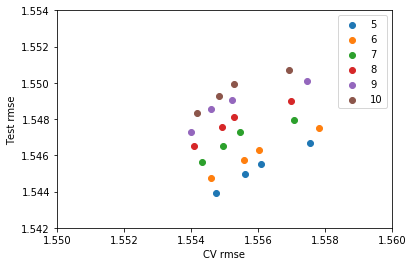

In [268]:
plt.figure()
for i in range(5,11):
    df=df_all2.loc[i]
    #df_err=df_all3.loc[i]
    plt.scatter(df.cv_error,df.test_error+(i-5)*0.001,linestyle='-',marker='o',label=i)
    #plt.errorbar(df.ave_cv_error,df.ave_test_error,xerr=df_err.cv_error)
    plt.ylabel('Test rmse')
    plt.xlabel('CV rmse')
    plt.legend()
    plt.xlim([1.550,1.560])
    plt.ylim([1.542,1.554])

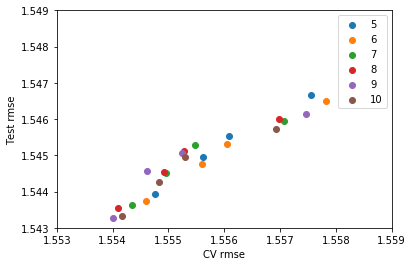

In [273]:
plt.figure()
for i in range(5,11):
    df=df_all2.loc[i]
    #df_err=df_all3.loc[i]
    plt.scatter(df.cv_error,df.test_error,linestyle='-',marker='o',label=i)
    #plt.errorbar(df.ave_cv_error,df.ave_test_error,xerr=df_err.cv_error)
    plt.ylabel('Test rmse')
    plt.xlabel('CV rmse')
    plt.legend()
    plt.xlim([1.553,1.559])
    plt.ylim([1.543,1.549])

## Finally, CV rmse is linear to Test rmse for model without outliers. For the model without outliers CV is not reliable probably due to outliers. Outliers affect rmse hugely. So we can focus on the model without outliers and improve our base model.

### I will do feature reduction for threshold 10 and replace values from my previous results. And see if we can observe improvements.

In [276]:
feats10=pd.read_csv('threshold_feature_elimination10_8extra_test10_without_outliers.csv',squeeze=True).tolist()

In [283]:
train_data=lgb.Dataset(train[train.outliers==0][feats10],label=train[train.outliers==0]['target'])

In [284]:
cv_score=lgb.cv(param,train_data,10000, verbose_eval=100, early_stopping_rounds = 600,stratified=False)

[100]	cv_agg's rmse: 1.60547 + 0.00964734
[200]	cv_agg's rmse: 1.57754 + 0.00878048
[300]	cv_agg's rmse: 1.56693 + 0.00814712
[400]	cv_agg's rmse: 1.56138 + 0.00770528
[500]	cv_agg's rmse: 1.55811 + 0.0074054
[600]	cv_agg's rmse: 1.55617 + 0.00721443
[700]	cv_agg's rmse: 1.55489 + 0.00711153
[800]	cv_agg's rmse: 1.55404 + 0.00699729
[900]	cv_agg's rmse: 1.55353 + 0.00695016
[1000]	cv_agg's rmse: 1.55317 + 0.00690121
[1100]	cv_agg's rmse: 1.5529 + 0.00685212
[1200]	cv_agg's rmse: 1.55266 + 0.00681777
[1300]	cv_agg's rmse: 1.55248 + 0.00674346
[1400]	cv_agg's rmse: 1.55233 + 0.00671699
[1500]	cv_agg's rmse: 1.55218 + 0.00667979
[1600]	cv_agg's rmse: 1.55209 + 0.0066453
[1700]	cv_agg's rmse: 1.552 + 0.00663538
[1800]	cv_agg's rmse: 1.55192 + 0.00661082
[1900]	cv_agg's rmse: 1.55184 + 0.00659594
[2000]	cv_agg's rmse: 1.55174 + 0.00660216
[2100]	cv_agg's rmse: 1.55171 + 0.00656293
[2200]	cv_agg's rmse: 1.55167 + 0.00653245
[2300]	cv_agg's rmse: 1.55168 + 0.00654575
[2400]	cv_agg's rmse: 1.5

In [287]:
len(cv_score['rmse-mean'])

3235

In [288]:
clf=lgb.train(param,train_data,len(cv_score['rmse-mean']),valid_sets=[train_data],verbose_eval=100, early_stopping_rounds = 600)

Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60184
[200]	training's rmse: 1.56997
[300]	training's rmse: 1.55583
[400]	training's rmse: 1.54695
[500]	training's rmse: 1.54033
[600]	training's rmse: 1.53503
[700]	training's rmse: 1.5305
[800]	training's rmse: 1.52646
[900]	training's rmse: 1.52282
[1000]	training's rmse: 1.51956
[1100]	training's rmse: 1.51638
[1200]	training's rmse: 1.51333
[1300]	training's rmse: 1.51044
[1400]	training's rmse: 1.50753
[1500]	training's rmse: 1.5048
[1600]	training's rmse: 1.50207
[1700]	training's rmse: 1.49935
[1800]	training's rmse: 1.49672
[1900]	training's rmse: 1.49412
[2000]	training's rmse: 1.49144
[2100]	training's rmse: 1.48891
[2200]	training's rmse: 1.48639
[2300]	training's rmse: 1.48389
[2400]	training's rmse: 1.4814
[2500]	training's rmse: 1.47887
[2600]	training's rmse: 1.47643
[2700]	training's rmse: 1.47385
[2800]	training's rmse: 1.47146
[2900]	training's rmse: 1.469
[3000]	training's rmse:

In [294]:
predictions=clf.predict(test[feats10],clf.best_iteration)

In [329]:
feats10_updated=feats10[:]

In [332]:
# remove outliers data
for i in range(len(feats10)):
    if 'outlier' in feats10[i]:
        feats10_updated.remove(feats10[i])

In [335]:
len(feats10_updated),len(feats10)

(81, 86)

In [336]:
train_data=lgb.Dataset(train[train.outliers==0][feats10_updated],label=train[train.outliers==0]['target'])
cv_score=lgb.cv(param,train_data,10000, verbose_eval=100, early_stopping_rounds = 600,stratified=False)

[100]	cv_agg's rmse: 1.60559 + 0.00973126
[200]	cv_agg's rmse: 1.57763 + 0.00875306
[300]	cv_agg's rmse: 1.56703 + 0.0080872
[400]	cv_agg's rmse: 1.56149 + 0.00770222
[500]	cv_agg's rmse: 1.55822 + 0.00736148
[600]	cv_agg's rmse: 1.55625 + 0.0071866
[700]	cv_agg's rmse: 1.55498 + 0.00710701
[800]	cv_agg's rmse: 1.55419 + 0.00699939
[900]	cv_agg's rmse: 1.55369 + 0.00690339
[1000]	cv_agg's rmse: 1.5533 + 0.00683223
[1100]	cv_agg's rmse: 1.55299 + 0.00677273
[1200]	cv_agg's rmse: 1.55276 + 0.00673547
[1300]	cv_agg's rmse: 1.55256 + 0.00670601
[1400]	cv_agg's rmse: 1.55238 + 0.00670275
[1500]	cv_agg's rmse: 1.55222 + 0.0066688
[1600]	cv_agg's rmse: 1.55211 + 0.00666149
[1700]	cv_agg's rmse: 1.55198 + 0.0066344
[1800]	cv_agg's rmse: 1.55193 + 0.00661063
[1900]	cv_agg's rmse: 1.55189 + 0.0065954
[2000]	cv_agg's rmse: 1.55181 + 0.00654826
[2100]	cv_agg's rmse: 1.55172 + 0.00654137
[2200]	cv_agg's rmse: 1.55167 + 0.00653846
[2300]	cv_agg's rmse: 1.55167 + 0.00655412
[2400]	cv_agg's rmse: 1.55

In [337]:
clf2=lgb.train(param,train_data,len(cv_score['rmse-mean']),valid_sets=[train_data],verbose_eval=100, early_stopping_rounds = 600)

Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.60193
[200]	training's rmse: 1.57019
[300]	training's rmse: 1.55608
[400]	training's rmse: 1.54719
[500]	training's rmse: 1.54064
[600]	training's rmse: 1.53533
[700]	training's rmse: 1.53084
[800]	training's rmse: 1.52681
[900]	training's rmse: 1.52326
[1000]	training's rmse: 1.51993
[1100]	training's rmse: 1.51672
[1200]	training's rmse: 1.51364
[1300]	training's rmse: 1.51074
[1400]	training's rmse: 1.50787
[1500]	training's rmse: 1.50506
[1600]	training's rmse: 1.50234
[1700]	training's rmse: 1.49961
[1800]	training's rmse: 1.49693
[1900]	training's rmse: 1.49432
[2000]	training's rmse: 1.49168
[2100]	training's rmse: 1.48913
[2200]	training's rmse: 1.48662
[2300]	training's rmse: 1.4841
[2400]	training's rmse: 1.48165
[2500]	training's rmse: 1.47914
[2600]	training's rmse: 1.47671
Did not meet early stopping. Best iteration is:
[2656]	training's rmse: 1.47526


In [338]:
predictions2=clf2.predict(test[feats10_updated],clf2.best_iteration)

In [340]:
predictions2.shape

(123623,)

In [345]:
df_submission2=pd.DataFrame({'card_id':test['card_id'].values,'target':predictions2})

In [347]:
df_submission2.to_csv('prediction_without_outliers_feature_reduction.csv',index=False)

In [321]:
# mixed with threshould value of 18000
best_submission=pd.read_csv("wang_lgb_cv_pur_date_1_updated_mixed_top20_top20_50.csv")

In [322]:
# we also need outliers predictions
outliers=pd.read_csv('wang_lgb_cv_pur_date_1_updated_outliers_pred.csv')

In [323]:
idx=outliers.sort_values('probability',ascending=False).head(18000).index

In [324]:
df_submission=pd.read_csv('submission.csv')
df_submission.target=predictions

In [325]:
df_submission.loc[idx,'target']=best_submission.loc[idx,'target']

In [326]:
df_submission.to_csv("wang_lgb_cv_pur_date_1_updated_mixed_top20_top20_50_updated_1.csv",index=False)
# LB:3.664 which is worser than previous 3.663


In [350]:
df_train.outliers.sum()

1766

Index(['first_active_month', 'card_id', 'feature_3', 'target',
       'auth_flag_purchase_amount_sum', 'auth_flag_authorized_flag_sum',
       'auth_flag_authorized_flag_mean', 'auth_flag_authorized_flag_std',
       'auth_flag_card_id_size', 'auth_encoder_category_2_auth_mean_mean',
       ...
       'feature_1_5', 'feature_2_1', 'feature_2_2', 'feature_2_3',
       'pur_freq_unique', 'pur_freq_unique_month', 'auth_pur_freq_unique',
       'auth_pur_freq_unique_month', 'nonauth_pur_freq_unique',
       'nonauth_freq_unique_month'],
      dtype='object', length=263)

#### Results are slightly worser than before which is probably due to threshould value

In [44]:
df2=df.copy()

In [58]:
df3=pd.concat([df2,df],join='outer',axis=0)

In [61]:
df3['total_fold']=10

In [63]:
df3['features']='feats'

In [85]:
df4=pd.DataFrame()

In [86]:
df4=pd.concat([df4,df],axis=0)

In [88]:
df4=pd.concat([df4,df],axis=0)

In [89]:
df4

,cv_error,test_error,fold,ave_cv_error,ave_test_error
0,3.658294,3.650502,1,3.648849,3.647493
1,3.650528,3.655088,2,3.648849,3.647493
2,3.650849,3.656602,3,3.648849,3.647493
3,3.607118,3.645048,4,3.648849,3.647493
4,3.651150,3.651565,5,3.648849,3.647493
5,3.675512,3.649566,6,3.648849,3.647493
6,3.606465,3.657148,7,3.648849,3.647493
7,3.623117,3.657314,8,3.648849,3.647493
8,3.683562,3.647405,9,3.648849,3.647493
9,3.680909,3.652111,10,3.648849,3.647493


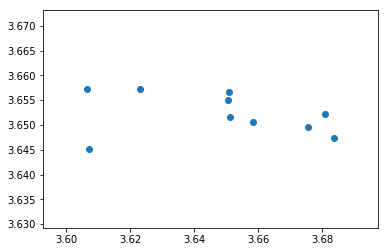

In [70]:
plt.figure()
plt.scatter(df['cv_error'],df['test_error'])

In [ ]:
for fold in [5,6,7,8,9,10]:
    for feat in [feats,feats1,feats2,feats3]:
         

### outlier detection

In [11]:
cl_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "scale_pos_weight": 15,
}

In [12]:
tr_data = lgb.Dataset(X_tr, label=y_tr.outlier)

In [13]:
cv_score = lgb.cv(cl_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=100)

[100]	cv_agg's auc: 0.902398 + 0.00697561
[200]	cv_agg's auc: 0.903697 + 0.00662913
[300]	cv_agg's auc: 0.903734 + 0.00670821
[400]	cv_agg's auc: 0.903137 + 0.00668533
[500]	cv_agg's auc: 0.902398 + 0.00650716
[600]	cv_agg's auc: 0.901779 + 0.00654513
[700]	cv_agg's auc: 0.901337 + 0.006394
[800]	cv_agg's auc: 0.900654 + 0.00646067


In [14]:
print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])

best num:  232 
best score: 0.9038768908290219


In [15]:
clf = lgb.train(cl_param, tr_data, 400, valid_sets=(tr_data), verbose_eval=100)

[100]	training's auc: 0.966905
[200]	training's auc: 0.974608
[300]	training's auc: 0.980398
[400]	training's auc: 0.984885


Original code
[100]	training's auc: 0.966946
[200]	training's auc: 0.974508
[300]	training's auc: 0.980274
[400]	training's auc: 0.984884

In [16]:
clf.best_iteration


0

In [17]:
prob = clf.predict(X_va, num_iteration=clf.best_iteration)

In [18]:
roc_auc_score(y_va.outlier, prob)

0.902935029308729

In [19]:
fpr, tpr, thr = roc_curve(y_va.outlier, prob)

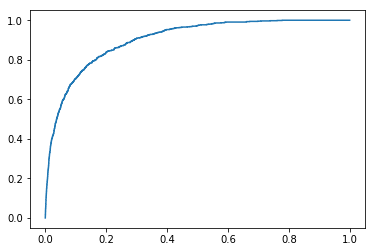

In [20]:
plt.plot(fpr, tpr)

In [21]:
print('outlier:', y_va.outlier.sum(), '\nnot outlier:', y_va.shape[0] - y_va.outlier.sum())

outlier: 869 
not outlier: 75860


In [22]:
for i in range(len(fpr)):
    real_outlier = int(tpr[i]*1351)
    not_outlier = int(fpr[i]*122272)
    total = real_outlier + not_outlier
    print(f'top {total}:  \toutlier {real_outlier} \t not outlier {not_outlier}')

top 0:  	outlier 0 	 not outlier 0
top 1:  	outlier 1 	 not outlier 0
top 5:  	outlier 1 	 not outlier 4
top 8:  	outlier 4 	 not outlier 4
top 10:  	outlier 4 	 not outlier 6
top 12:  	outlier 6 	 not outlier 6
top 14:  	outlier 6 	 not outlier 8
top 17:  	outlier 9 	 not outlier 8
top 18:  	outlier 9 	 not outlier 9
top 19:  	outlier 10 	 not outlier 9
top 26:  	outlier 10 	 not outlier 16
top 28:  	outlier 12 	 not outlier 16
top 29:  	outlier 12 	 not outlier 17
top 30:  	outlier 13 	 not outlier 17
top 35:  	outlier 13 	 not outlier 22
top 42:  	outlier 20 	 not outlier 22
top 63:  	outlier 20 	 not outlier 43
top 64:  	outlier 21 	 not outlier 43
top 72:  	outlier 21 	 not outlier 51
top 77:  	outlier 26 	 not outlier 51
top 80:  	outlier 26 	 not outlier 54
top 81:  	outlier 27 	 not outlier 54
top 83:  	outlier 27 	 not outlier 56
top 87:  	outlier 31 	 not outlier 56
top 89:  	outlier 31 	 not outlier 58
top 93:  	outlier 35 	 not outlier 58
top 105:  	outlier 35 	 not outlier

In [23]:
y_va_sort = y_va.copy()
y_va_sort['pred_prob'] = prob
y_va_sort = y_va_sort.sort_values('pred_prob', ascending=False)

In [24]:
y_va_sort.head()

,outlier,target,pred_prob
25347,1,-33.219281,0.859505
116144,0,-1.170125,0.840169
94554,0,-1.425834,0.839344
56803,0,2.033892,0.837220
42753,1,-33.219281,0.836045


In [25]:
y_va_sort.pred_prob.mean()

0.06602833315775794

In [26]:
outlier.mean()

0.010930233709890698

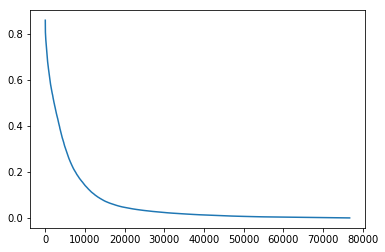

In [27]:
plt.plot(y_va_sort.pred_prob.values)

### regression

In [28]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [29]:
tr_data = lgb.Dataset(X_tr, label=y_tr.target)

In [30]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 3.6529 + 0.120686
[400]	cv_agg's rmse: 3.63521 + 0.118588
[600]	cv_agg's rmse: 3.6291 + 0.118203
[800]	cv_agg's rmse: 3.62684 + 0.118228
[1000]	cv_agg's rmse: 3.62651 + 0.118356
[1200]	cv_agg's rmse: 3.62603 + 0.11884
[1400]	cv_agg's rmse: 3.62662 + 0.118514
[1600]	cv_agg's rmse: 3.62699 + 0.118977


In [31]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  1149 
best score: 3.625740361079412


In [32]:
clf = lgb.train(rg_param, tr_data, 2000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 3.4864
[400]	training's rmse: 3.36918
[600]	training's rmse: 3.28943
[800]	training's rmse: 3.22785
[1000]	training's rmse: 3.17405
[1200]	training's rmse: 3.12344
[1400]	training's rmse: 3.07776
[1600]	training's rmse: 3.03531
[1800]	training's rmse: 2.99583
[2000]	training's rmse: 2.95647


In [33]:
clf.best_iteration

0

In [34]:
pred = clf.predict(X_va, num_iteration=clf.best_iteration)

In [35]:
get_lb(pred)

3.7026626002538454

In [36]:
y_va_sort.head()

,outlier,target,pred_prob
25347,1,-33.219281,0.859505
116144,0,-1.170125,0.840169
94554,0,-1.425834,0.839344
56803,0,2.033892,0.837220
42753,1,-33.219281,0.836045


#### let's see top20/50 stratory

In [37]:
pred_df = y_va.copy()
pred_df['pred_target'] = pred

In [38]:
pred_df['pred_prob'] = prob

In [39]:

index_20=pred_df.sort_values('pred_prob', ascending=False).head(20).index
index_20

Int64Index([ 25347, 116144,  94554,  56803,  42753,  12602,  51267, 135378,
             15933, 175726,  83942, 120610, 128262,  92357, 155132,   7071,
             82035, 148428, 102057, 159259],
           dtype='int64')

In [40]:
index_20

Int64Index([ 25347, 116144,  94554,  56803,  42753,  12602,  51267, 135378,
             15933, 175726,  83942, 120610, 128262,  92357, 155132,   7071,
             82035, 148428, 102057, 159259],
           dtype='int64')

In [41]:
pred_df.loc[pred_df.index.isin(index_20),'pred_target']=-33.21928095


In [42]:
pred_df.sort_values('pred_prob', ascending=False).head(20)

,outlier,target,pred_target,pred_prob
25347,1,-33.219281,-33.219281,0.859505
116144,0,-1.170125,-33.219281,0.840169
94554,0,-1.425834,-33.219281,0.839344
56803,0,2.033892,-33.219281,0.837220
42753,1,-33.219281,-33.219281,0.836045
12602,1,-33.219281,-33.219281,0.833862
51267,0,-1.420850,-33.219281,0.832792
135378,1,-33.219281,-33.219281,0.831966
15933,0,0.204692,-33.219281,0.831036
175726,1,-33.219281,-33.219281,0.827946


In [43]:
# Predicted test score
get_lb(pred_df.pred_target.values)

3.7147380551655145

### This discrepancy for our original set might be due to mainly.Two reasons: 1) We have  smaller number of outliers in test set than in real test set. 2 ) our prediction is not so accurate


In [44]:
test.shape[0]/y_va.shape[0]

1.6111639666879538

In [45]:
# so our threshould should be arround 16. Let's check it
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob
index_16=pred_df.sort_values('pred_prob', ascending=False).head(16).index
pred_df.loc[pred_df.index.isin(index_16),'pred_target']=-33.21928095
get_lb(pred_df.pred_target.values)

3.7126880379636393

## Now, let's just try to iterate more for each treshould values and observe results.

Text(0,0.5,'RMSE')

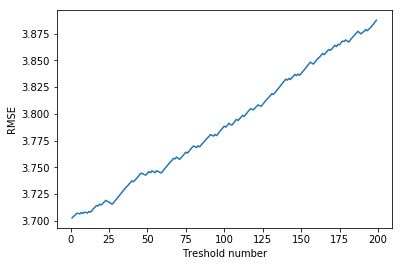

In [46]:
results=[]
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob
for i in range(1,200):
    index=pred_df.sort_values('pred_prob', ascending=False).head(i).index
    pred_df.loc[pred_df.index.isin(index),'pred_target']=-33.21928095
    results.append(get_lb(pred_df.pred_target.values))
plt.figure()
plt.plot(range(1,200),results)
plt.xlabel('Treshold number')
plt.ylabel('RMSE')

### We don't see any improvement at all. Probably, our outliers predictions are not so accurate. The reason why we can observe improvement in LB is due to more data for outliers prediction.

## Now, I will try to change our strategy for mixing with and without outliers. Instead of mixing prediction with and without outliers , I will separate dataset to two part so that together they will give best performance.

In [47]:
# We will start by using outliers predictions
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob

In [48]:
train.shape

(201917, 257)

In [49]:
cl_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "scale_pos_weight": 15,
}

In [50]:
tr_data = lgb.Dataset(X_tr, label=y_tr.outlier)

In [51]:
cv_score = lgb.cv(cl_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=100)

[100]	cv_agg's auc: 0.902398 + 0.00697561
[200]	cv_agg's auc: 0.903697 + 0.00662913
[300]	cv_agg's auc: 0.903734 + 0.00670821
[400]	cv_agg's auc: 0.903137 + 0.00668533
[500]	cv_agg's auc: 0.902398 + 0.00650716
[600]	cv_agg's auc: 0.901779 + 0.00654513
[700]	cv_agg's auc: 0.901337 + 0.006394
[800]	cv_agg's auc: 0.900654 + 0.00646067


In [52]:
print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])

best num:  232 
best score: 0.9038768908290219


In [53]:
clf_outlier = lgb.train(cl_param, tr_data, 400, valid_sets=(tr_data), verbose_eval=100)

[100]	training's auc: 0.966905
[200]	training's auc: 0.974608
[300]	training's auc: 0.980398
[400]	training's auc: 0.984885


Original code
[100]	training's auc: 0.966946
[200]	training's auc: 0.974508
[300]	training's auc: 0.980274
[400]	training's auc: 0.984884

In [54]:
clf_outlier.best_iteration


0

In [55]:
prob_train = clf_outlier.predict(X_tr, num_iteration=clf.best_iteration)

In [56]:
y_tr['prob_train']=prob_train

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
## Seems to really good! overfitting
y_tr.sort_values('prob_train',ascending=False).head()

,outlier,target,prob_train
88227,1,-33.219281,0.867037
45032,1,-33.219281,0.857329
100443,1,-33.219281,0.853597
13101,1,-33.219281,0.850782
22187,1,-33.219281,0.848931


In [58]:
y_tr.outlier.sum()

1338

Text(0.5,1,'Test set')

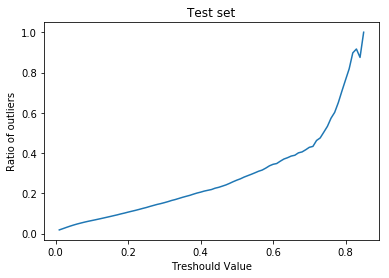

In [59]:
prob_outlier=[]
for i in range(1,86):
    i=i*0.01
    prob_outlier.append(y_tr[y_tr.prob_train>i].outlier.sum()/y_tr[y_tr.prob_train>i].shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,86)],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")

In [60]:
pred_df.head()

,outlier,target,pred_target,pred_prob
123115,0,-0.638506,-0.548086,0.002294
87051,0,0.084343,-0.077139,0.032504
122987,0,2.318157,0.425544,0.181516
188373,0,0.338946,-1.383379,0.049641
2165,0,0.537236,-0.251507,0.006939


In [61]:
int(round(pred_df.pred_prob.max()*100+1))

87

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


Text(0.5,1,'Test set')

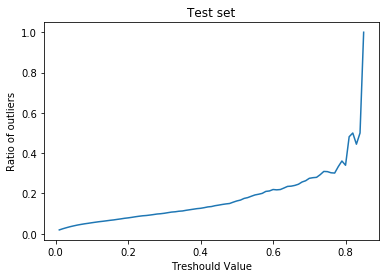

In [62]:
prob_outlier=[]
for i in range(1,int(round(pred_df.pred_prob.max()*100+1))):
    i=i*0.01
    prob_outlier.append(pred_df[pred_df.pred_prob>i].outlier.sum()/pred_df[pred_df.pred_prob>i].shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


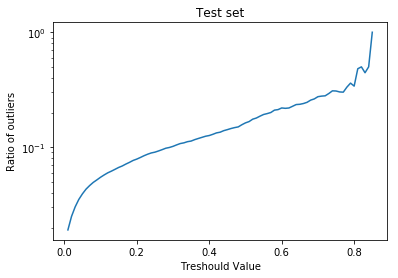

In [63]:
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")
plt.yscale('log')

Text(0.5,1,'Test set')

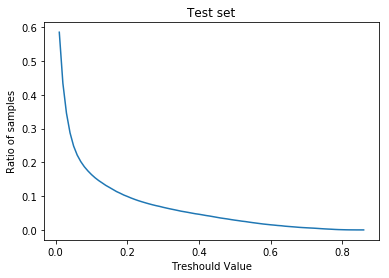

In [64]:
num=[]
for i in range(1,int(round(pred_df.pred_prob.max()*100+1))):
    i=i*0.01
    num.append(pred_df[pred_df.pred_prob>i].shape[0]/pred_df.shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],num)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of samples")
plt.title("Test set")

In [65]:
pred_df[pred_df.pred_prob>0.1].outlier.sum()

689

In [66]:
pred_df[pred_df.pred_prob<0.1].outlier.sum()

180

In [67]:
y_tr[y_tr.prob_train>0.01].outlier.sum()

1338

In [68]:
y_tr[y_tr.prob_train<0.01].outlier.sum()

0

In [69]:
# number of training examples
y_tr[y_tr.prob_train>0.01].shape[0],y_tr[y_tr.prob_train<0.01].shape[0]

(73465, 51723)

In [70]:
# number of test examples
pred_df[pred_df.pred_prob>0.1].shape[0],pred_df[pred_df.pred_prob<0.1].shape[0]

(12571, 64158)

### I have some random idea! Let's try it. We know that outlier is equial -10log(10). So, probably, it features are incoded by this function which is nonlinear. Maybe linear features will give better results.

In [121]:
linear_target=2**(y_tr.target/-10)

In [122]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [123]:
tr_data = lgb.Dataset(X_tr, label=linear_target)

In [124]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 0.895244 + 0.0368284
[400]	cv_agg's rmse: 0.893609 + 0.0359247
[600]	cv_agg's rmse: 0.893649 + 0.0357613
[800]	cv_agg's rmse: 0.893875 + 0.0357121
[1000]	cv_agg's rmse: 0.894176 + 0.0358264


In [126]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  466 
best score: 0.8935534391583646


In [127]:
clf = lgb.train(rg_param, tr_data, 500, valid_sets=(tr_data), verbose_eval=100)

[100]	training's rmse: 0.871901
[200]	training's rmse: 0.840926
[300]	training's rmse: 0.820992
[400]	training's rmse: 0.807409
[500]	training's rmse: 0.796093


In [128]:
clf.best_iteration

0

In [129]:
pred_log = clf.predict(X_va, num_iteration=clf.best_iteration)
pred_log=-10*np.log2(pred_lin)

In [130]:
# Huge error! It was worst idea Haha
get_lb(pred_log)

5.661605717551893

In [131]:
get_lb(pred_lin)

4.534825533330481

In [132]:
get_lb(pred)

3.7026626002538454

In [139]:
get_lb(np.array([0 for i in range(len(pred_lin))]))


3.9272538581303857

In [92]:
y_va2=y_va.copy()
y_va2['pred_log_target']=pred_log

In [141]:
# Equal to outlier
-10*np.log2(10),y_va2.target.min()

(-33.219280948873624, -33.21928095)

### Another, idea! Let's use outliers predictions as a feature for regression. It work for transperent conductor prediction maybe it can help to improve.

In [147]:
y_tr.prob_train.shape

(125188,)

In [160]:
y_tr.index

Int64Index([140457, 179764,  22899, 160544, 171908, 105318,  25836, 150503,
             50727, 127460,
            ...
            151181, 114565,  81844, 122929, 196886,  61872, 128963,  36482,
             40177, 150781],
           dtype='int64', length=125188)

In [8]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats].values, target_with_outlier, test_size=0.38, random_state=12)

In [9]:
X_tr.shape, X_va.shape, y_tr.shape, y_va.shape

((125188, 253), (76729, 253), (125188, 2), (76729, 2))

In [157]:
train2=train.copy()

In [164]:
train2['prob_outliers']=0

In [166]:
y_tr.head()

,outlier,target,prob_train
140457,0,0.013333,0.320053
179764,0,-0.946788,0.142976
22899,0,-0.301051,0.002098
160544,0,1.036026,0.037259
171908,0,-0.664374,0.018513


In [167]:
# filling prob_outliers for training set
train2.loc[train2.index.isin(y_tr.index),'prob_outliers']=y_tr.prob_train

In [176]:
train2.loc[train2.index.isin(y_va.index),'prob_outliers']=pred_df.pred_prob

In [178]:
feats2=feats[:]
feats2.append('prob_outliers')

In [183]:
X_tr2, X_va2, y_tr2, y_va2 = train_test_split(train2[feats2], target_with_outlier, test_size=0.38, random_state=12)

In [28]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [186]:
tr_data = lgb.Dataset(X_tr2, label=y_tr2.target)

In [187]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 2.94532 + 0.104668
[400]	cv_agg's rmse: 2.84243 + 0.0937743
[600]	cv_agg's rmse: 2.81018 + 0.0920099
[800]	cv_agg's rmse: 2.79241 + 0.0897408
[1000]	cv_agg's rmse: 2.78168 + 0.0901444
[1200]	cv_agg's rmse: 2.77516 + 0.0903369
[1400]	cv_agg's rmse: 2.7693 + 0.0909188
[1600]	cv_agg's rmse: 2.76438 + 0.0908424
[1800]	cv_agg's rmse: 2.76036 + 0.090435
[2000]	cv_agg's rmse: 2.75683 + 0.0901886
[2200]	cv_agg's rmse: 2.75392 + 0.0898743
[2400]	cv_agg's rmse: 2.75158 + 0.0896558
[2600]	cv_agg's rmse: 2.74916 + 0.0888359
[2800]	cv_agg's rmse: 2.74747 + 0.0887952
[3000]	cv_agg's rmse: 2.74619 + 0.0886733
[3200]	cv_agg's rmse: 2.7446 + 0.0883913
[3400]	cv_agg's rmse: 2.74309 + 0.0881613
[3600]	cv_agg's rmse: 2.74221 + 0.0882948
[3800]	cv_agg's rmse: 2.74153 + 0.0885056
[4000]	cv_agg's rmse: 2.74093 + 0.0884648
[4200]	cv_agg's rmse: 2.74016 + 0.0882647
[4400]	cv_agg's rmse: 2.7397 + 0.0881054
[4600]	cv_agg's rmse: 2.73896 + 0.0880526
[4800]	cv_agg's rmse: 2.73819 + 0.0882019
[

In [189]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  9949 
best score: 2.7332440508881763


## This is really amazing! It can be still improved I am worried about overfitting

In [190]:
# Let's try to fit until 10000 and 5000 and compare resutls
clf10 = lgb.train(rg_param, tr_data, 10000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492
[1200]	training's rmse: 2.05255
[1400]	training's rmse: 2.00259
[1600]	training's rmse: 1.95584
[1800]	training's rmse: 1.91521
[2000]	training's rmse: 1.8778
[2200]	training's rmse: 1.84573
[2400]	training's rmse: 1.81538
[2600]	training's rmse: 1.79068
[2800]	training's rmse: 1.76536
[3000]	training's rmse: 1.7436
[3200]	training's rmse: 1.72352
[3400]	training's rmse: 1.70347
[3600]	training's rmse: 1.68511
[3800]	training's rmse: 1.6676
[4000]	training's rmse: 1.64996
[4200]	training's rmse: 1.6339
[4400]	training's rmse: 1.61922
[4600]	training's rmse: 1.60532
[4800]	training's rmse: 1.59158
[5000]	training's rmse: 1.57752
[5200]	training's rmse: 1.56379
[5400]	training's rmse: 1.55201
[5600]	training's rmse: 1.53979
[5800]	training's rmse: 1.52849
[6000]	training's rmse: 1.51667
[6200]	training's rmse: 1.50534
[6400]	training'

In [191]:
clf5 = lgb.train(rg_param, tr_data, 5000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492
[1200]	training's rmse: 2.05255
[1400]	training's rmse: 2.00259
[1600]	training's rmse: 1.95584
[1800]	training's rmse: 1.91521
[2000]	training's rmse: 1.8778
[2200]	training's rmse: 1.84573
[2400]	training's rmse: 1.81538
[2600]	training's rmse: 1.79068
[2800]	training's rmse: 1.76536
[3000]	training's rmse: 1.7436
[3200]	training's rmse: 1.72352
[3400]	training's rmse: 1.70347
[3600]	training's rmse: 1.68511
[3800]	training's rmse: 1.6676
[4000]	training's rmse: 1.64996
[4200]	training's rmse: 1.6339
[4400]	training's rmse: 1.61922
[4600]	training's rmse: 1.60532
[4800]	training's rmse: 1.59158
[5000]	training's rmse: 1.57752


In [196]:
clf1 = lgb.train(rg_param, tr_data, 1000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492


In [33]:
clf.best_iteration

0

In [192]:
pred10 = clf10.predict(X_va2, num_iteration=clf.best_iteration)

In [194]:
pred5 = clf5.predict(X_va2, num_iteration=clf.best_iteration)

In [197]:
pred1 = clf1.predict(X_va2, num_iteration=clf.best_iteration)

In [198]:
get_lb(pred1)

3.821413304057852

In [195]:
get_lb(pred5)

3.835911155470752

In [193]:
get_lb(pred10)

3.8398787962019543

In [35]:
get_lb(pred2)

3.7026626002538454

### All of the above results are extremely bad since we are overfitting to test set. Instead we need to devide our test set to 

In [201]:
test.shape

(123623, 255)

In [203]:
train2.shape

(201917, 258)

In [11]:
from sklearn.model_selection import StratifiedKFold

In [215]:
train.shape

(201917, 257)

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [13]:
X_va.shape

(76729, 253)

In [14]:
target=y_tr.outlier
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "scale_pos_weight": 15,
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_out = np.zeros(len(X_tr))
predictions_out = np.zeros(len(X_va))
predictions_out_final = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_out[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_out += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_out_final += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits


np.sqrt(mean_squared_error(oof_out, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.917183	valid_1's auc: 0.91992
[200]	training's auc: 0.924252	valid_1's auc: 0.921347
[300]	training's auc: 0.929413	valid_1's auc: 0.921534
[400]	training's auc: 0.933795	valid_1's auc: 0.921478
Early stopping, best iteration is:
[355]	training's auc: 0.931838	valid_1's auc: 0.921751
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.918611	valid_1's auc: 0.906582
[200]	training's auc: 0.925213	valid_1's auc: 0.908707
[300]	training's auc: 0.929988	valid_1's auc: 0.910282
[400]	training's auc: 0.934385	valid_1's auc: 0.911197
[500]	training's auc: 0.938165	valid_1's auc: 0.91164
[600]	training's auc: 0.941646	valid_1's auc: 0.91179
[700]	training's auc: 0.944731	valid_1's auc: 0.911839
[800]	training's auc: 0.947757	valid_1's auc: 0.911896
Early stopping, best iteration is:
[723]	training's auc: 0.945501	valid_1's auc: 0.911964
fold 2
Training until v

0.17040935323352144

In [15]:
# Large error
np.sqrt(mean_squared_error(oof_out, target))

0.17040935323352144

### Let's look at relatio of predicted target to predicted outliers

In [16]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [17]:
y_tr.head()

,outlier,target
140457,0,0.013333
179764,0,-0.946788
22899,0,-0.301051
160544,0,1.036026
171908,0,-0.664374


In [18]:

target=y_tr.target
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_reg = np.zeros(len(X_tr))
predictions_reg = np.zeros(len(X_va))
predictions_final = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_reg[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_reg += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_final += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof_reg, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.58046	valid_1's rmse: 3.66991
[200]	training's rmse: 3.46286	valid_1's rmse: 3.63273
[300]	training's rmse: 3.39054	valid_1's rmse: 3.61732
[400]	training's rmse: 3.33437	valid_1's rmse: 3.61146
[500]	training's rmse: 3.28756	valid_1's rmse: 3.60716
[600]	training's rmse: 3.24652	valid_1's rmse: 3.60529
[700]	training's rmse: 3.20942	valid_1's rmse: 3.60469
[800]	training's rmse: 3.17664	valid_1's rmse: 3.60481
[900]	training's rmse: 3.14277	valid_1's rmse: 3.60478
[1000]	training's rmse: 3.11189	valid_1's rmse: 3.60485
Early stopping, best iteration is:
[933]	training's rmse: 3.1324	valid_1's rmse: 3.60412
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.5773	valid_1's rmse: 3.68439
[200]	training's rmse: 3.45854	valid_1's rmse: 3.65424
[300]	training's rmse: 3.38404	valid_1's rmse: 3.6419
[400]	training's rmse: 3.3258	valid_1's rmse: 3.63482
[50

3.630738758585358

### Amazing we have less error with smaller dataset.
3.649012733482272 before splitting
Now,
3.6329832506410753

In [21]:
y_va['predicted_target']=predictions_reg

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
# Almost similar results for test set
get_lb(y_va.predicted_target.values)

3.7002935017637917

In [23]:
y_tr['predicted_target']=oof_reg
y_va['predicted_target']=predictions_reg
y_tr['prob_out']=oof_out
y_va['prob_out']=predictions_out

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [24]:
y_va_sorted=y_va.sort_values('prob_out',ascending=False)
y_tr_sorted=y_tr.sort_values('prob_out',ascending=False)

In [25]:
y_va_sorted=y_va_sorted[y_va_sorted.prob_out>0.5]
y_tr_sorted=y_tr_sorted[y_tr_sorted.prob_out>0.5]

In [26]:
y_tr_sorted.shape[0],y_va_sorted.shape[0]

(4050, 2495)

In [27]:
ratio_va=[]
number_va=[]
ratio_tr=[]
number_tr=[]
for i in range(0,-25,-1):
    n_va=y_va_sorted[y_va_sorted.predicted_target<i].shape[0]
    number_va.append(n_va)
    ratio_va.append(y_va_sorted[y_va_sorted.predicted_target<i].outlier.sum()/n_va)
    
    n_tr=y_tr_sorted[y_tr_sorted.predicted_target<i].shape[0]
    number_tr.append(n_tr)
    ratio_tr.append(y_tr_sorted[y_tr_sorted.predicted_target<i].outlier.sum()/n_tr)
    

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


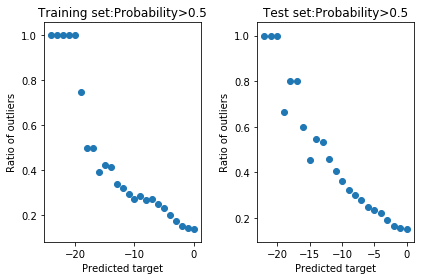

In [28]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(range(0,-25,-1),ratio_tr)
plt.ylabel('Ratio of outliers')
plt.xlabel('Predicted target')
plt.title('Training set:Probability>0.5')
plt.subplot(1,2,2)
plt.scatter(range(0,-25,-1),ratio_va)
plt.ylabel('Ratio of outliers')
plt.xlabel('Predicted target')
plt.title('Test set:Probability>0.5')
plt.tight_layout()
plt.show()

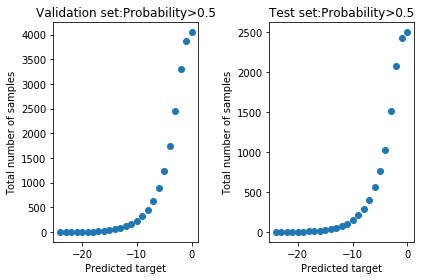

In [29]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(range(0,-25,-1),number_tr)
plt.ylabel('Total number of samples')
plt.xlabel('Predicted target')
plt.title('Validation set:Probability>0.5')
plt.subplot(1,2,2)
plt.scatter(range(0,-25,-1),number_va)
plt.ylabel('Total number of samples')
plt.xlabel('Predicted target')
plt.title('Test set:Probability>0.5')
plt.tight_layout()



In [30]:
y_tr.loc[:,['predicted_target','prob_out']].head()

,predicted_target,prob_out
140457,-2.384720,0.417188
179764,-1.318909,0.240523
22899,0.133268,0.007925
160544,0.827795,0.054423
171908,-0.150823,0.026663


In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
reg = LinearRegression().fit(y_tr.loc[:,['predicted_target','prob_out']],y_tr.loc[:,'target'])
print(reg.score(y_tr.loc[:,['predicted_target','prob_out']],y_tr.loc[:,'target']))
reg_pred=reg.predict(y_va.loc[:,['predicted_target','prob_out']])
get_lb(reg_pred)
#Almost no improvement haha


0.09521932410967981


3.7000553656609774

In [35]:
reg_score=[]
test_score=[]
for num in range(1,1000):
    reg = LinearRegression().fit(y_tr_sorted.loc[:,['predicted_target','prob_out']].head(num),y_tr_sorted.loc[:,'target'].head(num))
    reg_score.append(reg.score(y_tr_sorted.loc[:,['predicted_target','prob_out']].head(num),y_tr_sorted.loc[:,'target'].head(num)))
    pred=reg.predict(y_va_sorted.loc[:,['predicted_target','prob_out']].head(num))
    target=y_va.predicted_target.copy()
    target.loc[target.index.isin(y_va_sorted.head(num).index)]=pred
    test_score.append(get_lb(target))
    

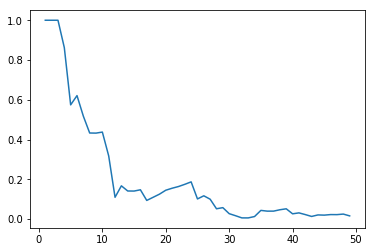

In [36]:
plt.figure()
plt.plot(range(1,50),reg_score[0:49])

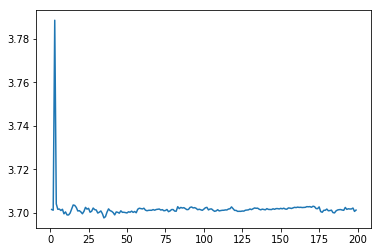

In [37]:
plt.figure()
plt.plot(range(1,200),test_score[:199])

In [39]:
target=y_va.target.copy()

In [40]:
target.loc[target.index.isin(y_va_sorted.head(20).index)]=-30

In [41]:
get_lb(y_va.predicted_target.values)

3.7002935017637917

In [ ]:
import random

In [ ]:
a=[]
for i in range(1000):
    a+=random.choices([0,1],weights=[0.9,0.1])

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [13]:
X_va.shape

(76729, 253)

In [49]:
target=y_tr.outlier
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "scale_pos_weight": 15,
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_out_proba = np.zeros(len(X_tr))
predictions_out_proba = np.zeros(len(X_va))
predictions_out_final_proba = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_out_proba[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_out_proba += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_out_final_proba += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits


#np.sqrt(mean_squared_error(oof_out, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0671082	valid_1's binary_logloss: 0.0720479
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0484886	valid_1's binary_logloss: 0.0502096
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0664381	valid_1's binary_logloss: 0.0720133
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0483025	valid_1's binary_logloss: 0.0507281
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0655342	valid_1's binary_logloss: 0.0750983
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0481346	valid_1's binary_logloss: 0.0516465
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0656604	valid_1's binary_logloss: 0.074284
Early stopping, best iteration is:
[11]	training's binary_logloss:

In [52]:
y_tr['pred_proba']=oof_out_proba
y_va['pred_proba']=predictions_out_proba

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
y_va.sort_values('pred_proba',ascending=False)

,outlier,target,predicted_target,prob_out,pred_proba
121556,0,-0.330013,-15.395987,0.815893,0.104791
59156,0,-3.076884,-13.947709,0.785804,0.104791
145192,0,0.381281,-7.360986,0.676012,0.104727
139384,1,-33.219281,-14.083611,0.826792,0.104485
25347,1,-33.219281,-22.582171,0.850167,0.104402
94554,0,-1.425834,-19.563889,0.855501,0.104316
68825,0,-0.553302,-12.175527,0.807013,0.103644
151711,0,-0.399803,-10.127872,0.795408,0.103634
179088,1,-33.219281,-12.416098,0.812498,0.103634
63172,0,1.455046,-12.974710,0.817353,0.103634


In [ ]:
random.choices(population, weights=None, *, cum_weights=None, k=1)¶
